# Imports

In [2]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import pickle

In [2]:
#Base Directories
base_dir = "Telecommunications_Industry/csv files/"
csv_dir = "created CSVs/"
model_dir = "saved models/"

# Read data

### List all the columns in each table 

In [3]:
#read all the available files / tables and create a set of all the unique columns available
list_of_files = os.listdir(base_dir)

set_of_columns_available = set()

for file in list_of_files:
    if ".csv" in file:
        df = pd.read_csv(base_dir + file)
        cols_in_df = df.columns.tolist()
        
        set_of_columns_available.update(cols_in_df)
        print("Columns in file:", file, "are", cols_in_df)
        print()
        
print("Total number of attributes / columns available :", len(set_of_columns_available))
print(set_of_columns_available)

Columns in file: CustomerChurn.csv are ['LoyaltyID', 'Customer ID', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn']

Columns in file: Telco_customer_churn.csv are ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason']

Columns in file: Telco_customer_churn_demographics.csv are ['Customer ID', 'Coun

---
**Note :** Each table has a common unique "Customer ID" as a primary key execpt the Population table which has the population count cooresponding to unique Zip Codes as primary key.

### Combine all the tables to create a overall complete dataset

In [4]:
#We can combine multiple files using Customer ID as primary key
#first read all the tables dataframes

df = pd.read_csv(base_dir + "Telco_customer_churn.csv")

#There are two ways "Customer ID" is written in column names: one with and one without space 
#fix column name to "Customer ID" in "Telco_customer_churn.csv" file
df = df.rename(columns = {'CustomerID':'Customer ID'})

list_of_csvs = ['CustomerChurn.csv', 
                'Telco_customer_churn_demographics.csv',
                'Telco_customer_churn_location.csv',
                'Telco_customer_churn_population.csv',
                'Telco_customer_churn_services.csv',
                'Telco_customer_churn_status.csv']

for file in list_of_csvs:
    temp = pd.read_csv(base_dir + file)

    if "Customer ID" in temp.columns.tolist():
        df = pd.merge(df, temp, on = "Customer ID", how = "left", suffixes=('', '_remove'))
        #df.join(temp.set_index("Customer ID"), on = "Customer ID") 
    else:
        df = pd.merge(df, temp, on = "Zip Code", how = "left", suffixes=('', '_remove'))
            
# remove the duplicate columns
df.drop([i for i in df.columns if 'remove' in i], axis = 1, inplace = True)

print("Total Number of columns : ", len(df.columns))
print("List of columns :", df.columns.tolist())
df.head()

Total Number of columns :  65
List of columns : ['Customer ID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason', 'LoyaltyID', 'Tenure', 'Churn', 'Age', 'Under 30', 'Married', 'Number of Dependents', 'Location ID', 'ID', 'Population', 'Service ID', 'Quarter', 'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Offer', 'Avg Monthly Long Distance Charges', 'Internet Type', 'Avg Monthly GB Download', 'Device Protection Plan', 'Premium Tech Support', 'Streaming Music', 'Unlimited Data', 'Monthly Charge', 'Total Refunds', 'Total Extra Data Charges', 'Total Lon

,Customer ID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Unlimited Data,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Status ID,Satisfaction Score,Customer Status,Churn Category
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Yes,53.85,0.0,0,20.94,129.09,SUDNGT6444,1,Churned,Competitor
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Yes,70.70,0.0,0,18.24,169.89,KZSZDV8891,2,Churned,Other
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,99.65,0.0,0,97.20,917.70,EPTIUU1269,3,Churned,Other
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,104.80,0.0,0,136.92,3182.97,PAJIVH8196,3,Churned,Other
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,103.70,0.0,0,2172.17,7208.47,RXFOMV1173,1,Churned,Competitor


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Count                              7043 non-null   int64  
 2   Country                            7043 non-null   object 
 3   State                              7043 non-null   object 
 4   City                               7043 non-null   object 
 5   Zip Code                           7043 non-null   int64  
 6   Lat Long                           7043 non-null   object 
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Gender                             7043 non-null   object 
 10  Senior Citizen                     7043 non-null   object 
 11  Partner                            7043 non-null   objec

In [6]:
#save the complete dataframe with all the attributes combined into a single table
df.to_csv(csv_dir + "Telecom_Customer_Churn_Complete.csv")

# Data Preprocessing 

## Dealing with Null values

**Observations:** when we see the overview of dataset using df.info() we can see the datatypes of all the columns and we can also observe that all the columns have 7043 (all) not null values except the "Churn Category" and "Churn Reason" columns because they contain the reason why customer churned and how and they are only available for users that have left (churned). We can fill the null values with the constant value of "Not Churned" or "Not Applicable". - This column can be used for EDA.

In [7]:
columns_with_null_values = [(col, df[col].isnull().sum()) for col in df.columns.tolist() if df[col].isnull().sum() > 0]
columns_with_null_values

[('Churn Reason', 5174), ('Churn Category', 5174)]

In [8]:
# replacing na values in "Churn Category" with "Not Applicable"
df["Churn Category"].fillna("Not Applicable", inplace = True)

# replacing na values in "Churn Reason" with "Not Churned"
df["Churn Reason"].fillna("Not Churned", inplace = True)

In [9]:
#data type of total charges column is object - as it contains null values as blank space strings
#we need to replace that with 0.0
df["Total Charges"] = np.where(df["Total Charges"] == " ", '0.0', df["Total Charges"])
df["Total Charges"] = df["Total Charges"].astype(float)

## Data Wrangling

In [10]:
for col in df.columns.tolist():
    print(col)
    print("Number of unique values:", df[col].nunique())
    print("Unique Values:", df[col].unique()[:10])
    
    if(df[col].dtype == 'int64' or df[col].dtype == 'float64'):
        print("max :", df[col].max())
        print("min :", df[col].min())

    print()

Customer ID
Number of unique values: 7043
Unique Values: ['3668-QPYBK' '9237-HQITU' '9305-CDSKC' '7892-POOKP' '0280-XJGEX'
 '4190-MFLUW' '8779-QRDMV' '1066-JKSGK' '6467-CHFZW' '8665-UTDHZ']

Count
Number of unique values: 1
Unique Values: [1]
max : 1
min : 1

Country
Number of unique values: 1
Unique Values: ['United States']

State
Number of unique values: 1
Unique Values: ['California']

City
Number of unique values: 1129
Unique Values: ['Los Angeles' 'Beverly Hills' 'Huntington Park' 'Lynwood'
 'Marina Del Rey' 'Inglewood' 'Santa Monica' 'Torrance' 'Whittier'
 'La Habra']

Zip Code
Number of unique values: 1652
Unique Values: [90003 90005 90006 90010 90015 90020 90022 90024 90028 90029]
max : 96161
min : 90001

Lat Long
Number of unique values: 1652
Unique Values: ['33.964131, -118.272783' '34.059281, -118.30742' '34.048013, -118.293953'
 '34.062125, -118.315709' '34.039224, -118.266293'
 '34.066367, -118.309868' '34.02381, -118.156582' '34.066303, -118.435479'
 '34.099869, -118.326

Looking at the variables and there definations, we can see that we have some wrangling to do.

- We will change “No internet service” to “No” for six columns, they are: “Online Security”, “Online Backup”, “Device Protection”, “Tech Support”, “streaming TV”, “streaming Movies”.

- We will change “No phone service” to “No” for column “Multiple Lines”

- Remove all the uneccessary columns

- Since the minimum tenure is 1 month and maximum tenure is 72 months, we can group them into five tenure groups: “0–12 Month”, “12–24 Month”, “24–48 Months”, “48–60 Month”, “> 60 Month”

- Convert Population stored as string with commas into numerical values.

- We also have to convert ("yes", "No"), ("Male", "Female") and other categorical column values into one-hot encoding.

### Replace Column values and group values in bins

In [11]:
#columns in which we want to replace "No internet service" with "No"
cols_to_change = ["Online Security", "Online Backup", "Device Protection", "Tech Support", "Streaming TV", "Streaming Movies"]
# Applying the condition
df[cols_to_change] = np.where(df[cols_to_change] == "No internet service", "No", df[cols_to_change])

#for "Multiple Lines" column
df["Multiple Lines"] = np.where(df["Multiple Lines"] == "No phone service", "No", df["Multiple Lines"])

In [12]:
#group tenure in bins:
df["Tenure Bins"] = pd.cut(df['Tenure in Months'], [0, 12, 24, 48, 60, 72])
df.value_counts("Tenure Bins")

Tenure Bins
(0, 12]     2186
(24, 48]    1594
(60, 72]    1407
(12, 24]    1024
(48, 60]     832
dtype: int64

In [13]:
#convert numbers as strings into integers 
df["Population"] = df['Population'].str.replace(',','').astype(int)

### Removing uneccessary columns

we can observe some columns that contain IDs represent some unique IDs cooresponding to users - let's look at them one by one and figure out if our model will be able to extract any information from those attributes or not. And there are also columns that have same value for all the users so there is no information to be learned there - like all data is from California, United States - so state and country columns in our case are useless.

In [14]:
#list of columns to be droped / removed - because there is no information to be extracted from those columns / attributes
list_of_columns_to_drop = []

#### Customer ID

In [15]:
#Customer ID attribute
print(df["Customer ID"].head())
print("\n Number of Unique Values: ", df["Customer ID"].nunique())

0    3668-QPYBK
1    9237-HQITU
2    9305-CDSKC
3    7892-POOKP
4    0280-XJGEX
Name: Customer ID, dtype: object

 Number of Unique Values:  7043


In [16]:
#We can see that there all the values in this column are unique strings - just used for Identification of user
#which so not have a clear interpretation and cannot help us determine if a customer will churn or not!!
df.set_index("Customer ID", inplace = True)

#### Count

In [17]:
#Count attribute
print(df["Count"].head())
print("\n Number of Unique Values: ", df["Count"].nunique())

Customer ID
3668-QPYBK    1
9237-HQITU    1
9305-CDSKC    1
7892-POOKP    1
0280-XJGEX    1
Name: Count, dtype: int64

 Number of Unique Values:  1


In [18]:
#Opposite of Customer ID, count has the same value for each and every user regardless of whether they churn or not
list_of_columns_to_drop.append("Count")

#### Country

In [19]:
#Country attribute
print(df["Country"].head())
print("\n Number of Unique Values: ", df["Country"].nunique())

Customer ID
3668-QPYBK    United States
9237-HQITU    United States
9305-CDSKC    United States
7892-POOKP    United States
0280-XJGEX    United States
Name: Country, dtype: object

 Number of Unique Values:  1


In [20]:
#same as count same value for all users - nothing to learn
list_of_columns_to_drop.append("Country")

#### State

In [21]:
#State attribute
print(df["State"].head())
print("\n Number of Unique Values: ", df["State"].nunique())

Customer ID
3668-QPYBK    California
9237-HQITU    California
9305-CDSKC    California
7892-POOKP    California
0280-XJGEX    California
Name: State, dtype: object

 Number of Unique Values:  1


In [22]:
#same as Country same value for all users - nothing to learn
list_of_columns_to_drop.append("State")

#### Churn Label

In [23]:
#Churn Label attribute
print(df["Churn Label"].head())
print("\n Number of Unique Values: ", df["Churn Label"].nunique())

Customer ID
3668-QPYBK    Yes
9237-HQITU    Yes
9305-CDSKC    Yes
7892-POOKP    Yes
0280-XJGEX    Yes
Name: Churn Label, dtype: object

 Number of Unique Values:  2


In [24]:
(df["Churn"] == df["Churn Label"]).all()

True

In [25]:
#this column has exact same values as the churn column
list_of_columns_to_drop.append("Churn Label")

#### Location ID

In [26]:
#Location ID attribute
print(df["Location ID"].head())
print("\n Number of Unique Values: ", df["Location ID"].nunique())

Customer ID
3668-QPYBK    PZZUIT6837
9237-HQITU    CKNALR2542
9305-CDSKC    VCQKYE1638
7892-POOKP    SNLISG8671
0280-XJGEX    YTSGZA8582
Name: Location ID, dtype: object

 Number of Unique Values:  7043


In [27]:
#We can see that there all the values in this column are unique strings - coordinates will be more useful for understanding location info
#which so not have a clear interpretation and cannot help us determine if a customer will churn or not!!
list_of_columns_to_drop.append("Location ID")

#### ID

In [28]:
#ID attribute
print(df["ID"].head())
print("\n Number of Unique Values: ", df["ID"].nunique())

Customer ID
3668-QPYBK     3
9237-HQITU     5
9305-CDSKC     6
7892-POOKP     9
0280-XJGEX    14
Name: ID, dtype: int64

 Number of Unique Values:  1652


In [29]:
#According to the defination of column given in dataset - this column was just used to identify row number in population table 
#and does not correspond to any info about our users 
list_of_columns_to_drop.append("ID")

#### Service ID

In [30]:
#Service ID attribute
print(df["Service ID"].head())
print("\n Number of Unique Values: ", df["Service ID"].nunique())

Customer ID
3668-QPYBK    ZLZTZWPWE3351
9237-HQITU    GXJVSQIYH4715
9305-CDSKC    KDUHHRQBI5663
7892-POOKP    WXXQTNEZW3786
0280-XJGEX    LTNFDWAMC2575
Name: Service ID, dtype: object

 Number of Unique Values:  7043


In [31]:
#just used to identify rows in services table - does not convey any meaning about users
list_of_columns_to_drop.append("Service ID")

#### Quarter

In [32]:
#Quarter attribute
print(df["Quarter"].head())
print("\n Number of Unique Values: ", df["Quarter"].nunique())

Customer ID
3668-QPYBK    Q3
9237-HQITU    Q3
9305-CDSKC    Q3
7892-POOKP    Q3
0280-XJGEX    Q3
Name: Quarter, dtype: object

 Number of Unique Values:  1


In [33]:
#same as count - same value for all users - no info to be extracted
list_of_columns_to_drop.append("Quarter")

#### Status ID

In [34]:
#Status ID attribute
print(df["Status ID"].head())
print("\n Number of Unique Values: ", df["Status ID"].nunique())

Customer ID
3668-QPYBK    SUDNGT6444
9237-HQITU    KZSZDV8891
9305-CDSKC    EPTIUU1269
7892-POOKP    PAJIVH8196
0280-XJGEX    RXFOMV1173
Name: Status ID, dtype: object

 Number of Unique Values:  7043


In [35]:
#We can see that there all the values in this column are unique strings 
#which so not have a clear interpretation and cannot help us determine if a customer will churn or not!!
list_of_columns_to_drop.append("Status ID")

#### Loyalty ID

In [36]:
#LoyaltyID attribute
print(df["LoyaltyID"].head())
print("\n Number of Unique Values: ", df["LoyaltyID"].nunique())

Customer ID
3668-QPYBK    326527
9237-HQITU    503388
9305-CDSKC    160192
7892-POOKP    582674
0280-XJGEX    933642
Name: LoyaltyID, dtype: int64

 Number of Unique Values:  7021


In [37]:
#We can see that there almost all the values in this column are unique numbers
#with not so clear interpretation and cannot help us determine if a customer will churn or not!!
list_of_columns_to_drop.append("LoyaltyID")

#### Some others - duplicate columns, have same info, data leakage

There are some repeat and some very similar columns: 
- "Tenure Months", "Tenure" and "Tenure in Months" - check definations in dataset
    - they are almost the same but we have better description of "Tenure in Months" in dataset so we'll keep that
- "Churn" and "Churn Value"
    - same but one numerical and one string - we'll keep the numerical one (Churn Value) as our ML Models work with numerical data
- "Internet Type" and "Internet Service" - check definations
    - we'll keep "Internet Service" as it is the one included in churn table by default.
- "Total Revenue" and "Total Charges" - definations
    - the coloumns contain different values revenue > charges - so maybe revenue includes some other things not included here. They are related so check for correlation
- "Monthly Charge" and "Monthly Charges":
    - the are essentialy the same column with slightly different names - we will keep "Monthly Charges"
- "Tenure in Months"
    - we have modified data to store tenure by grouping them into bins in the column "Tenure bins"

In [38]:
list_of_columns_to_drop.append("Tenure")
list_of_columns_to_drop.append("Tenure Months")
list_of_columns_to_drop.append("Churn")
list_of_columns_to_drop.append("Internet Type")
list_of_columns_to_drop.append("Monthly Charge")
list_of_columns_to_drop.append("Tenure in Months")

- some columns that essentially convey the same information like "Zip Code", "Lat Long", "Latitude", "Longitude"
    - we can only keep latitude and longitude information as "Lat Long" have both of them combined only, and Zip Codes are Unique strings of Numbers which by themselves do not convey any information.
    
- the "City" column has very high cardinality (1129) for our model to learn it will be better to learn location information using just latitude and longitude values

In [39]:
list_of_columns_to_drop.append("Lat Long")
list_of_columns_to_drop.append("Zip Code")
list_of_columns_to_drop.append("City")

In the dataset provided we have 2 columns "Churn reason" and "Churn category" which contain information only about the users that have churned if they are used for training, they directly indicate that the user has churned and such information will not be available to us before churning to make future predictions.

"Customer Status" is also a source of data leakage as it indicated whether customer will stay, leave or join at the end.

In [40]:
list_of_columns_to_drop.append("Churn Reason")
list_of_columns_to_drop.append("Churn Category")
list_of_columns_to_drop.append("Customer Status")

Two columns in dataset "Churn Score", "CLTV" are described as the predictions made by team at IBM about what are the chances of a customer churn, which can give a clear indication whether customer will churn or not, but it is not specified how these metrics are evaluated and these metrics will not be available when trying to make predictions in general, so it is best to not include them.

In [41]:
list_of_columns_to_drop.append("CLTV")
list_of_columns_to_drop.append("Churn Score")

#### Remove / drop not useful columns from table / dataframe

In [42]:
list_of_columns_to_drop

['Count',
 'Country',
 'State',
 'Churn Label',
 'Location ID',
 'ID',
 'Service ID',
 'Quarter',
 'Status ID',
 'LoyaltyID',
 'Tenure',
 'Tenure Months',
 'Churn',
 'Internet Type',
 'Monthly Charge',
 'Tenure in Months',
 'Lat Long',
 'Zip Code',
 'City',
 'Churn Reason',
 'Churn Category',
 'Customer Status',
 'CLTV',
 'Churn Score']

In [43]:
df.drop(list_of_columns_to_drop, axis = 1, inplace = True)

In [44]:
#Add a new column to represent Satisfaction score as categorical variable for EDA 
df['Satisfaction Score Label'] = df['Satisfaction Score'].astype('category')

In [45]:
#rename the target column "Churn Value" to just "Churn"
df.rename(columns = {'Churn Value' : 'Churn'}, inplace = True)

In [46]:
df.to_csv(csv_dir + "Selected_columns_customer_churn.csv")

In [47]:
df.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,...,Premium Tech Support,Streaming Music,Unlimited Data,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Tenure Bins,Satisfaction Score Label
Customer ID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,33.964131,-118.272783,Male,No,No,No,Yes,No,DSL,Yes,...,No,No,Yes,0.0,0,20.94,129.09,1,"(0, 12]",1
9237-HQITU,34.059281,-118.307420,Female,No,No,Yes,Yes,No,Fiber optic,No,...,No,No,Yes,0.0,0,18.24,169.89,2,"(0, 12]",2
9305-CDSKC,34.048013,-118.293953,Female,No,No,Yes,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,0.0,0,97.20,917.70,3,"(0, 12]",3
7892-POOKP,34.062125,-118.315709,Female,No,Yes,Yes,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,0.0,0,136.92,3182.97,3,"(24, 48]",3
0280-XJGEX,34.039224,-118.266293,Male,No,No,Yes,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,0.0,0,2172.17,7208.47,1,"(48, 60]",1


# EDA (Exploratory Data Analysis)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Latitude                           7043 non-null   float64 
 1   Longitude                          7043 non-null   float64 
 2   Gender                             7043 non-null   object  
 3   Senior Citizen                     7043 non-null   object  
 4   Partner                            7043 non-null   object  
 5   Dependents                         7043 non-null   object  
 6   Phone Service                      7043 non-null   object  
 7   Multiple Lines                     7043 non-null   object  
 8   Internet Service                   7043 non-null   object  
 9   Online Security                    7043 non-null   object  
 10  Online Backup                      7043 non-null   object  
 11  Device Protection                

## Univariate Analysis

### Distribution of target label - "Churn"

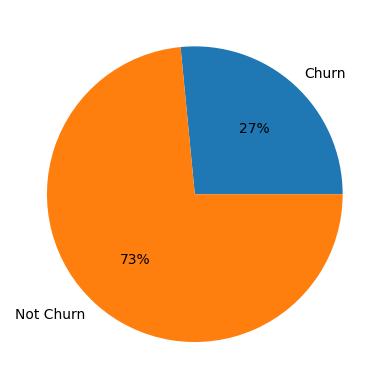

In [50]:
#let's take a look at our target label - "Churn" first
counts = [(df["Churn"] == 1).sum(), (df["Churn"] == 0).sum()]
plt.pie(counts, labels = ["Churn", "Not Churn"], autopct='%.0f%%')
plt.show()

**Note:** there seems to be data imbalance which we will have to handle when implementing models for prediction, as imbalance in data distribution can affect our model's accuracy and also affects evalution metrics like accuracy score to be misleading.

### Bar plots of categorical variables

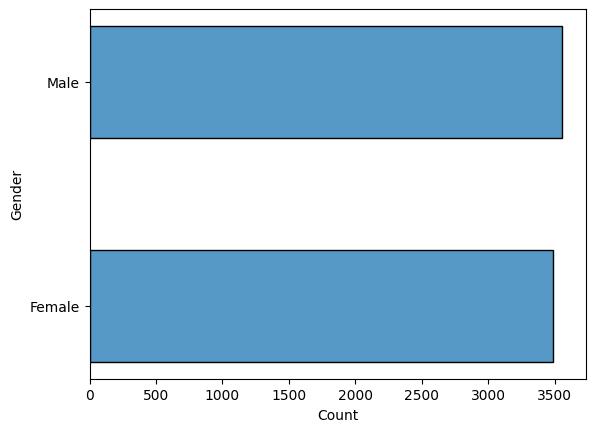

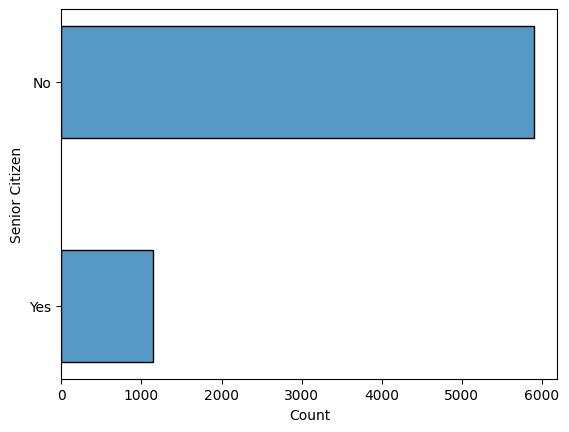

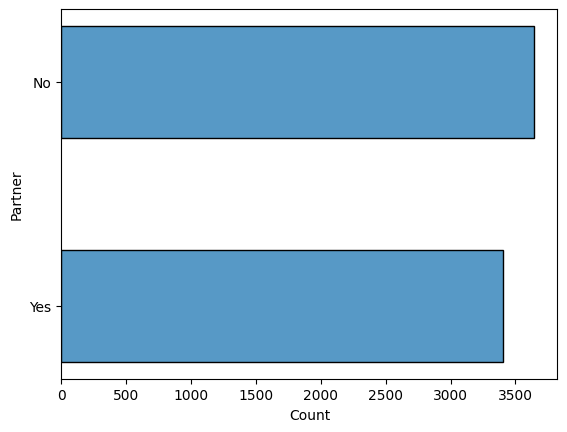

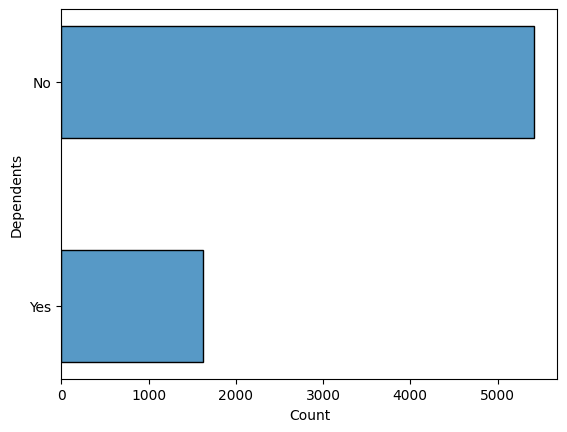

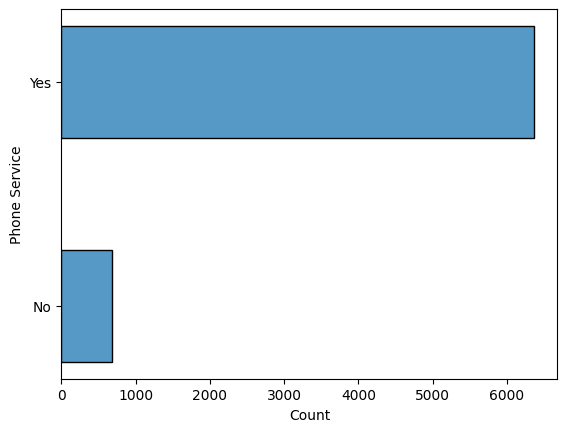

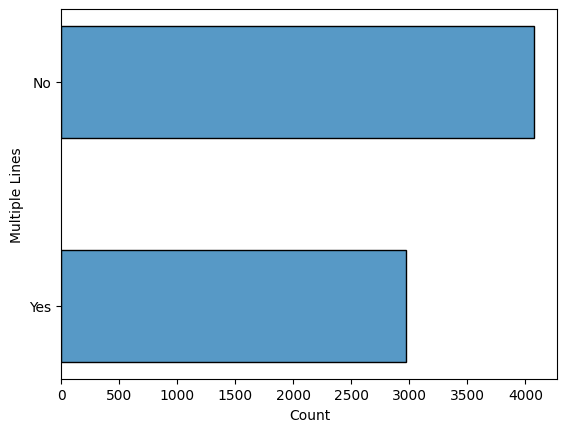

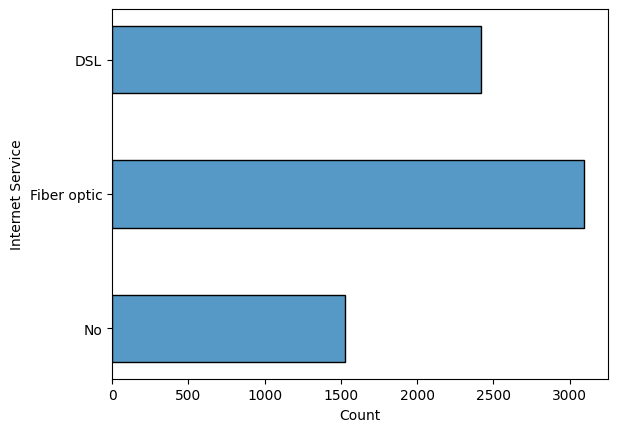

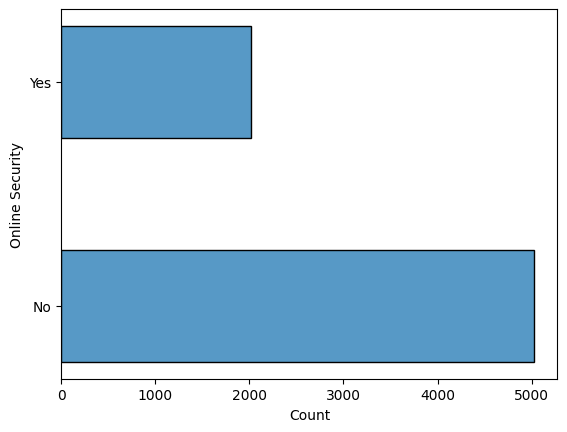

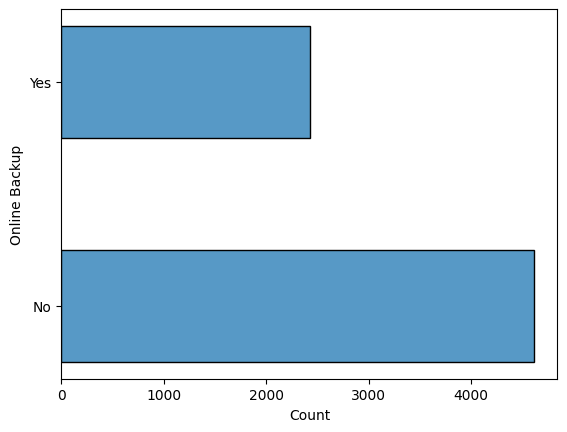

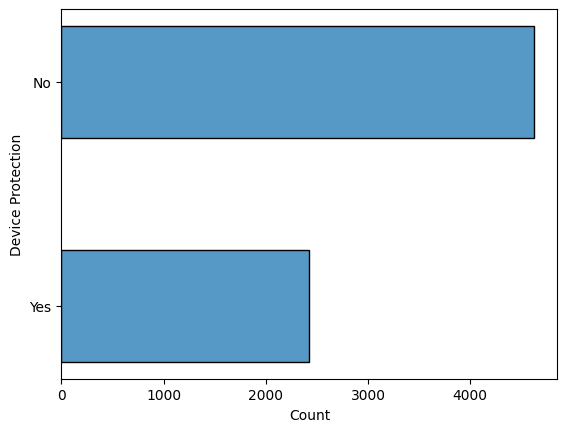

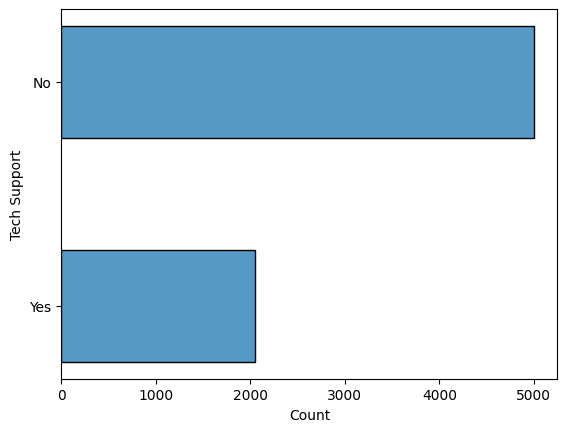

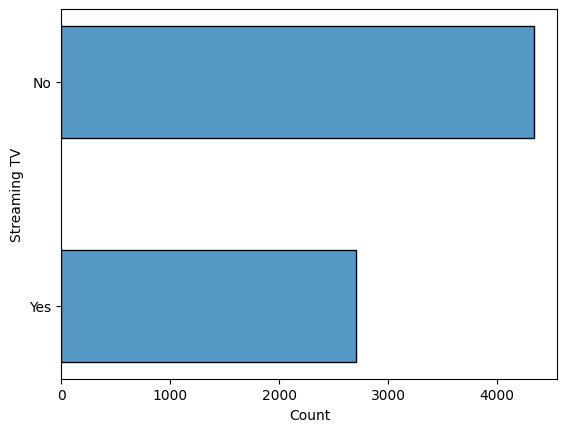

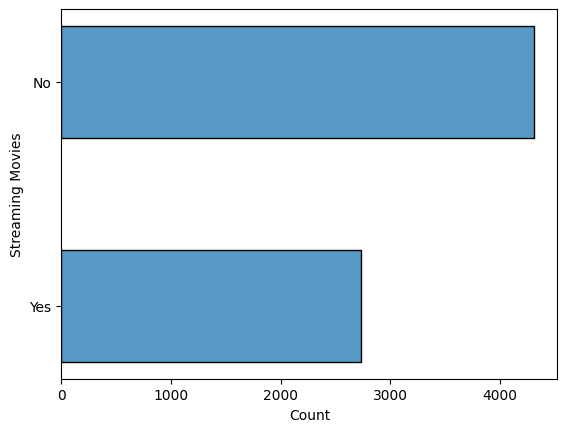

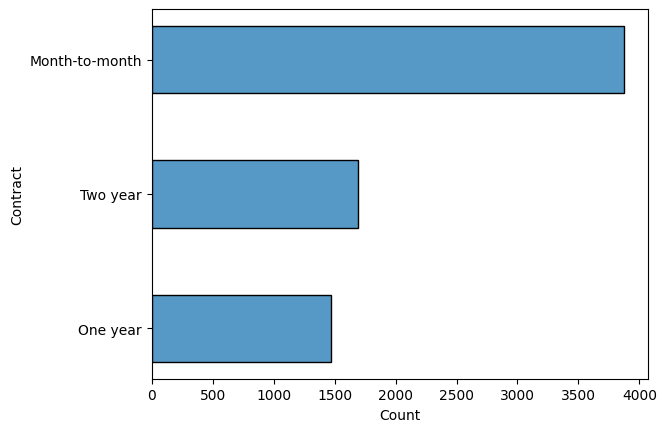

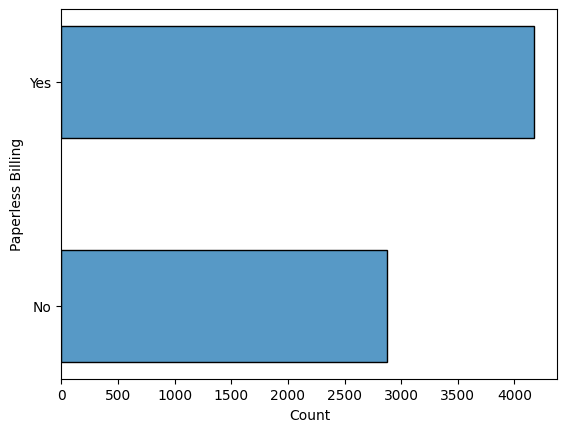

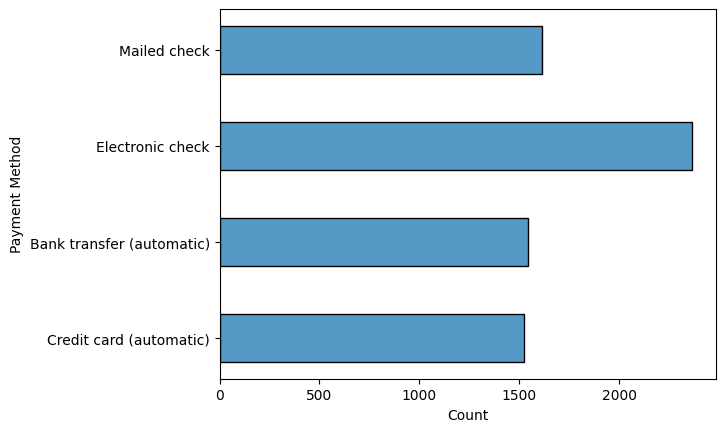

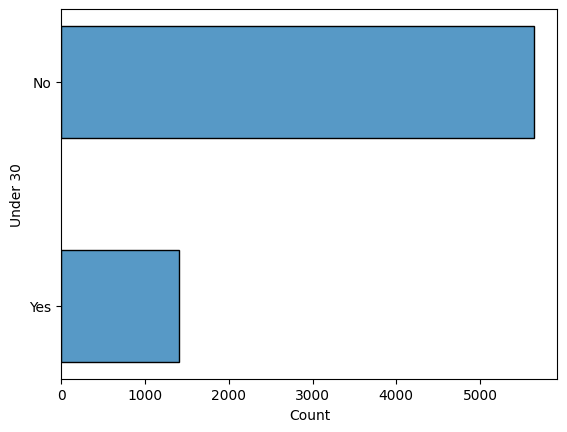

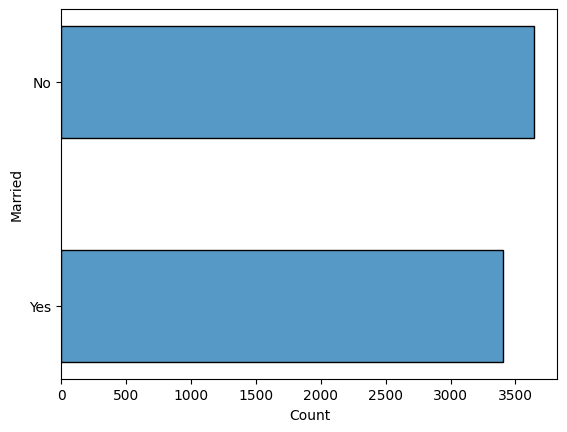

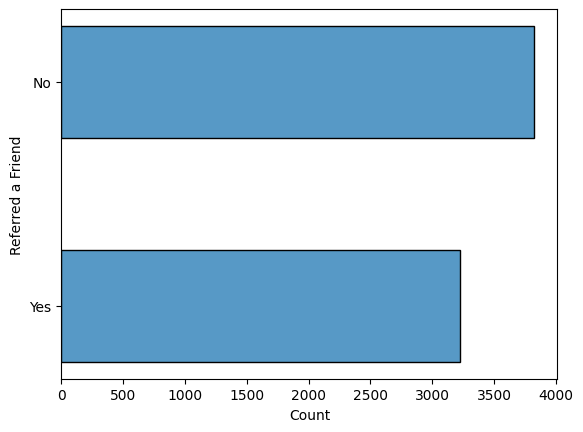

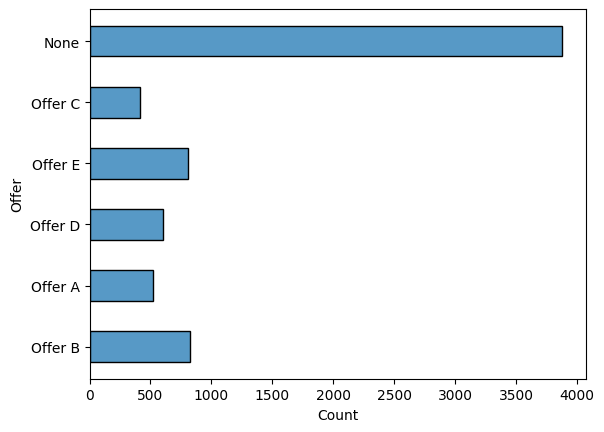

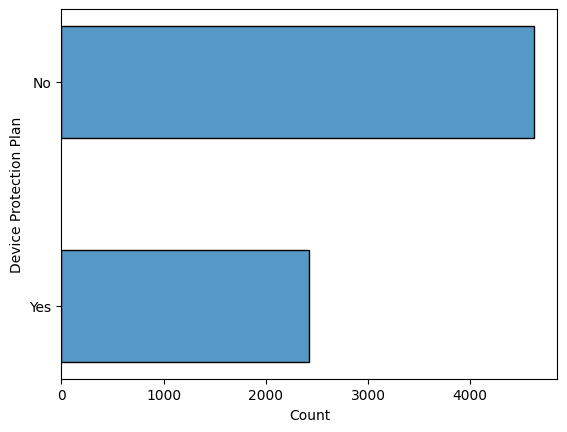

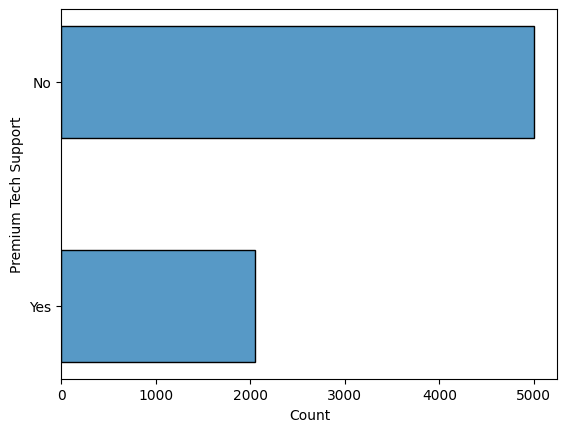

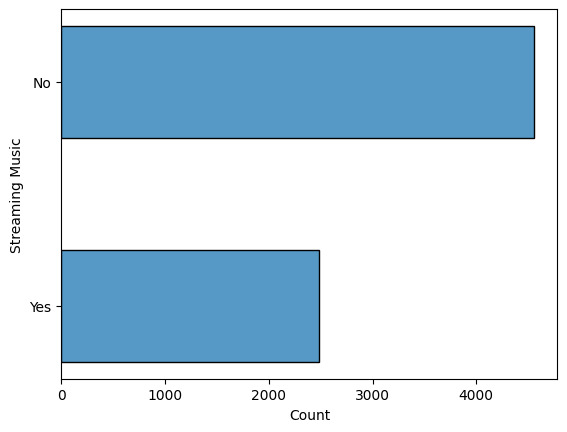

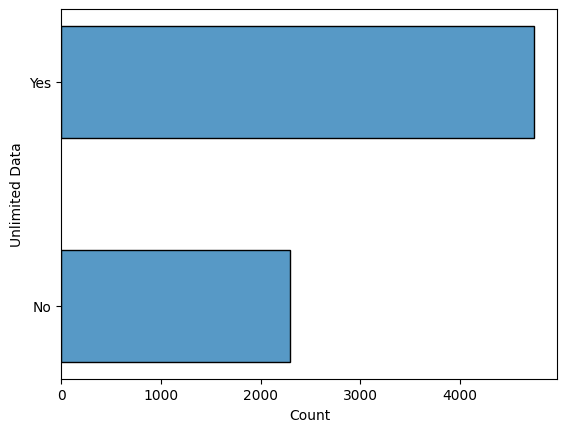

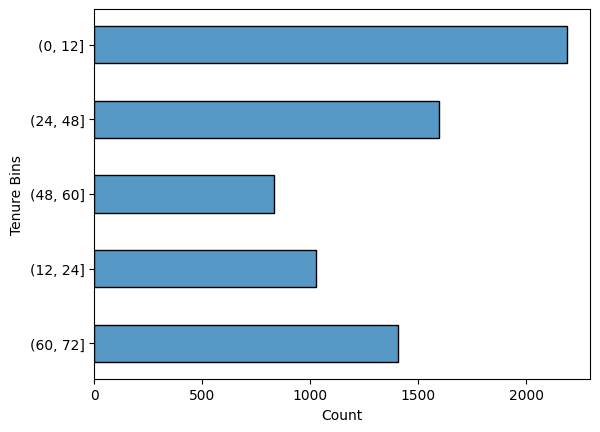

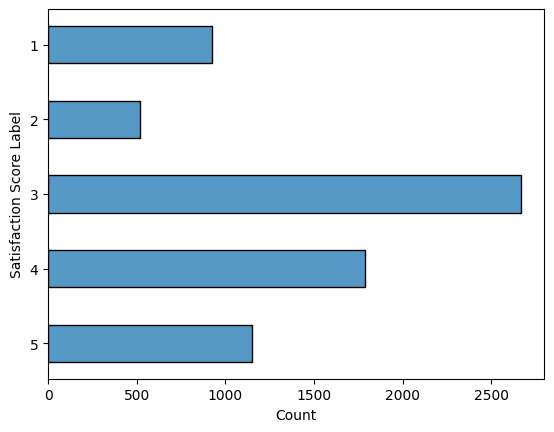

In [51]:
for col in df.columns.tolist():
    if(df[col].dtype == 'object'):
        plt.figure()
        sns.histplot(data = df, y = col, shrink=0.5)
        plt.show()
    elif df[col].dtype == 'category':
        temp = df.copy()
        temp[col] = df[col].astype(str)
        plt.figure()
        sns.histplot(data = temp, y = col, shrink=0.5)
        plt.show()

All of the categorical variables seem to have a reasonably broad distribution, therefore, all of them will be kept for the further analysis.

### Churn cooresponding to different values of attributes / columns

I then went ahead to see how other categorical columns varied with the Churn column.

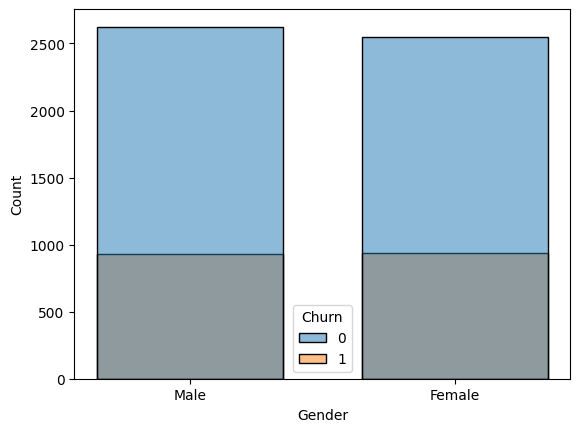

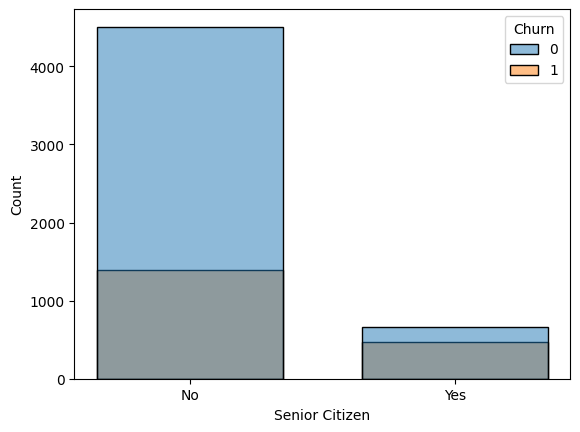

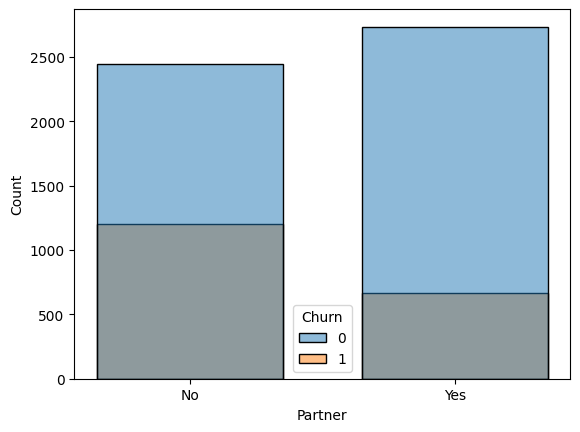

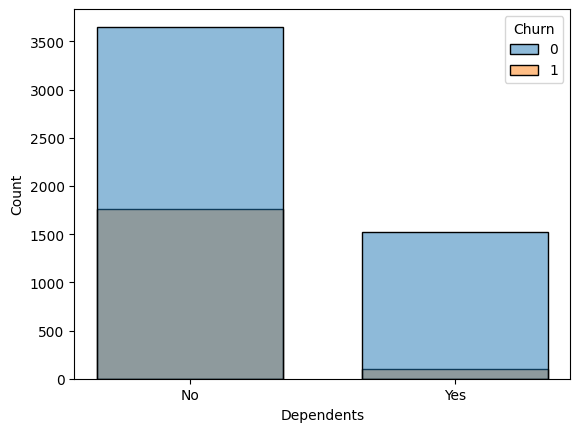

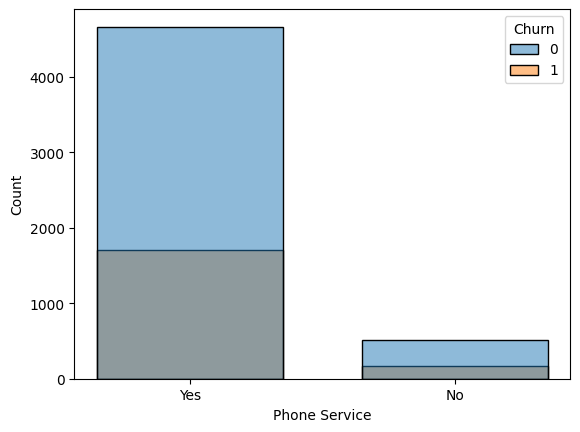

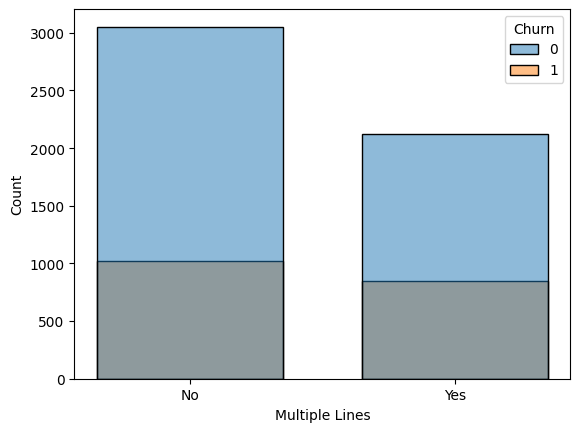

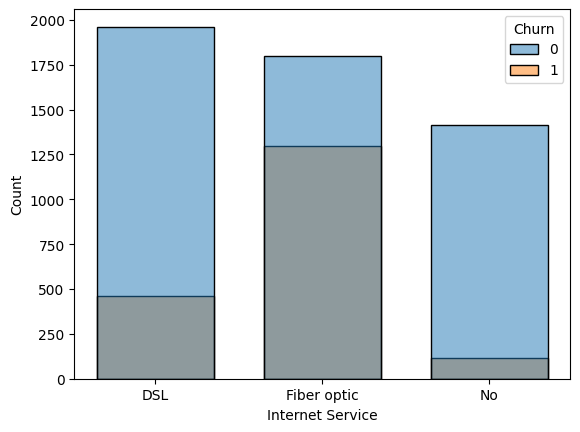

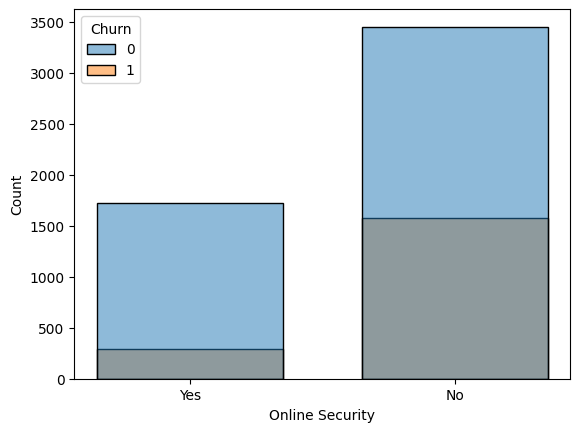

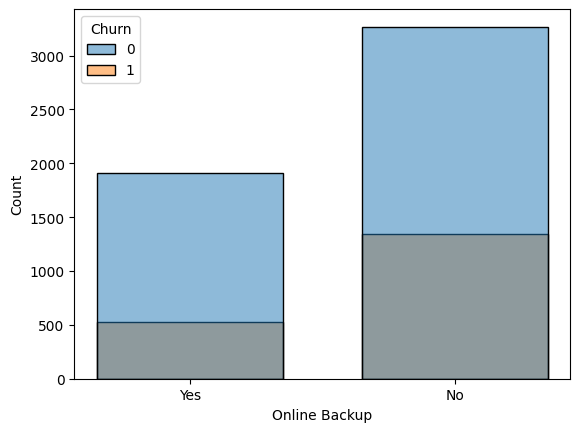

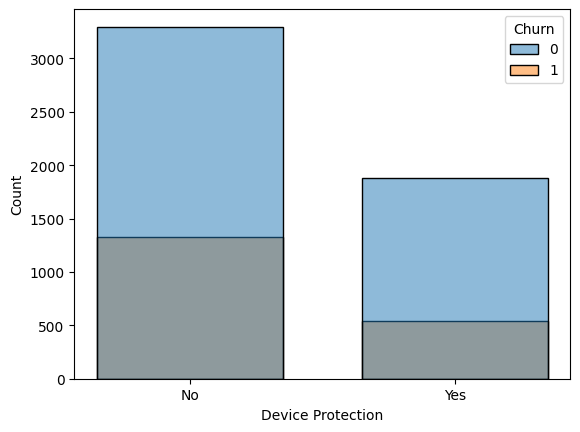

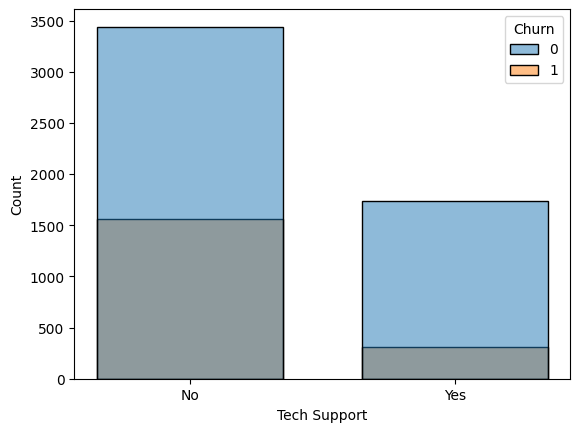

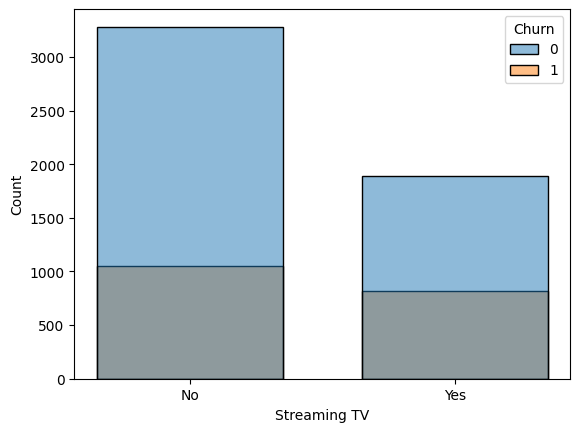

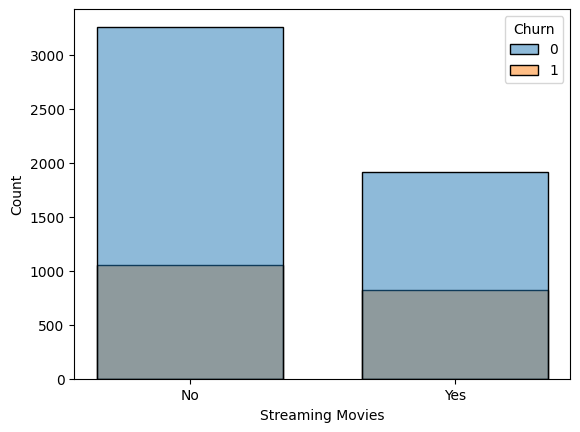

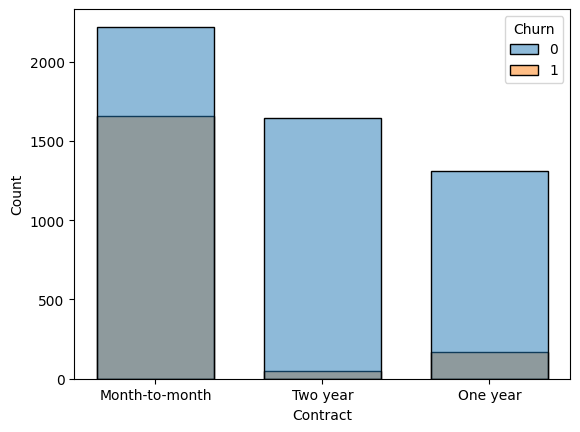

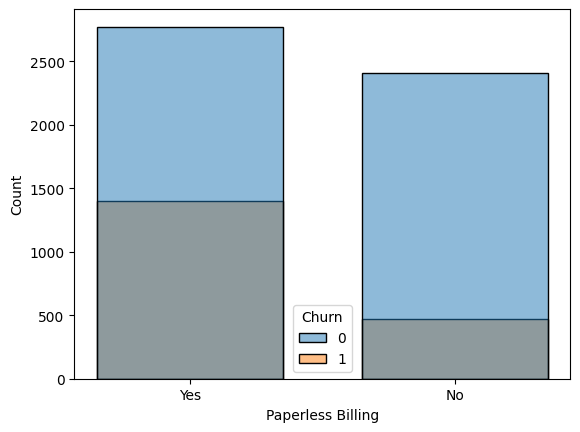

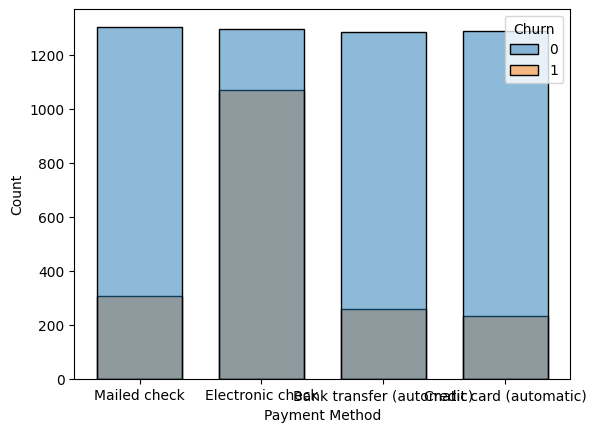

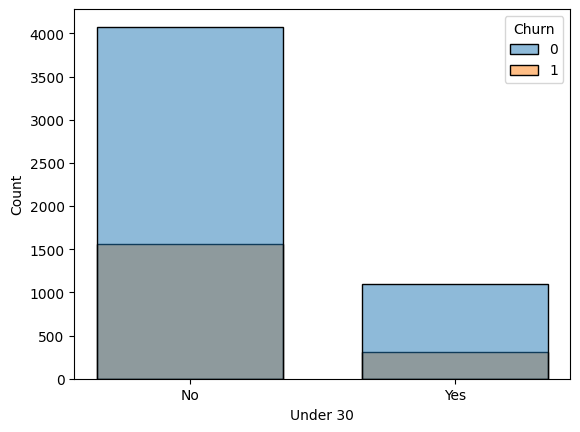

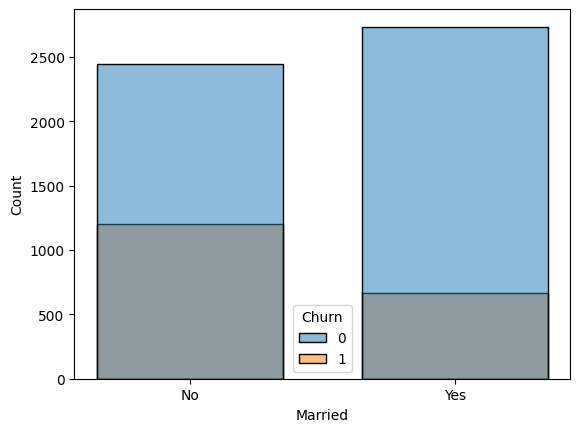

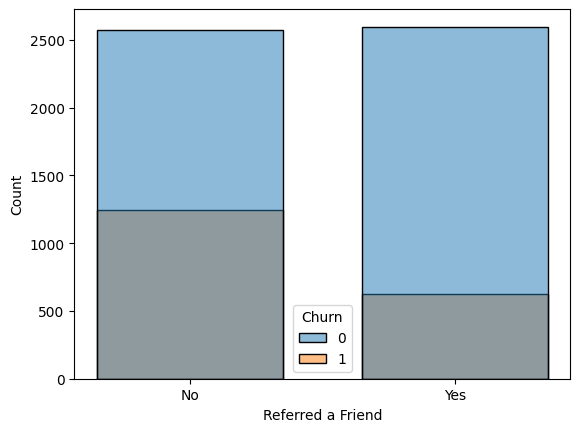

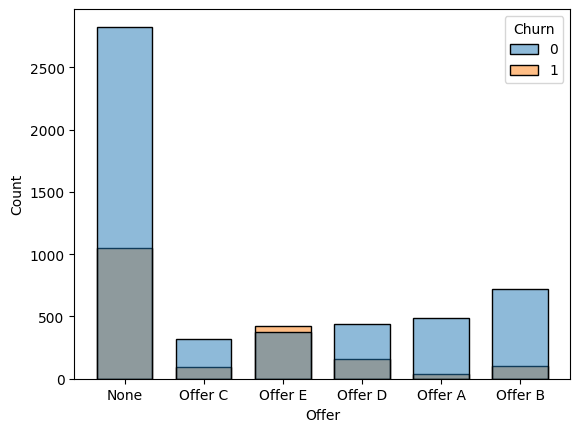

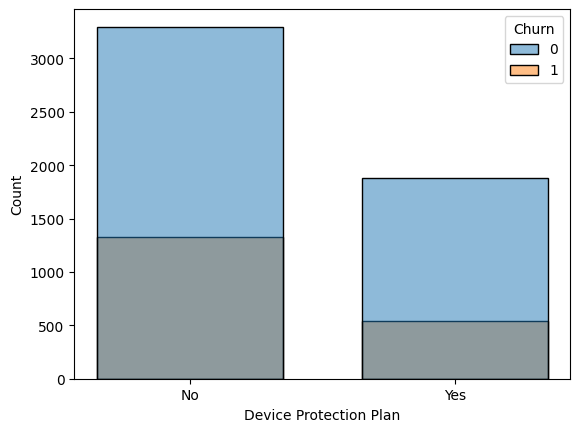

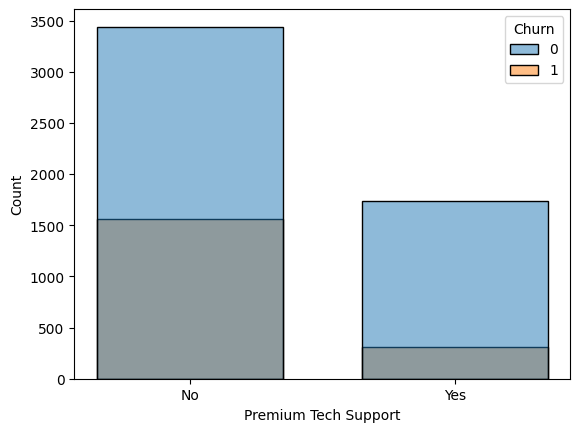

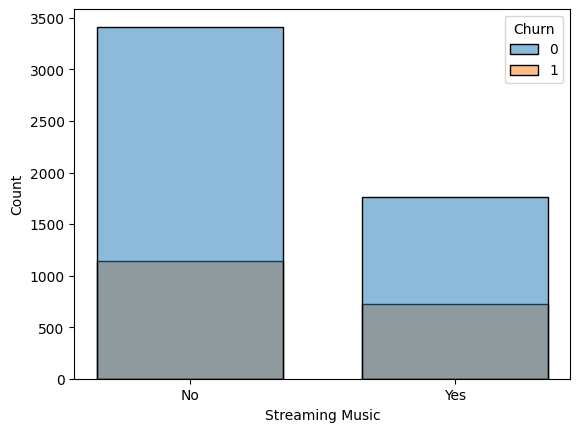

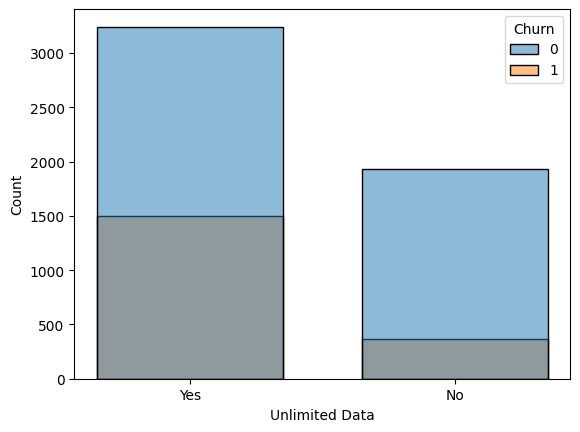

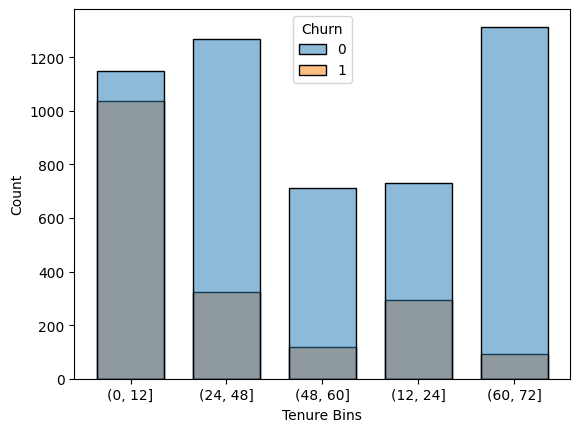

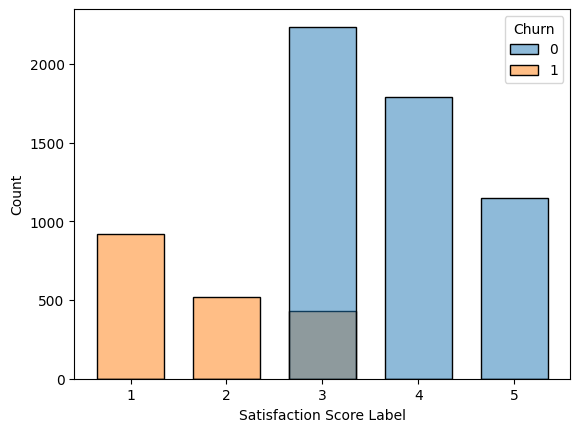

In [52]:
for col in df.columns.tolist():
    if col != "Churn" and df[col].dtype == 'object':
        plt.figure()
        sns.histplot(df, hue="Churn", x = col, shrink=.7, multiple="layer")
        plt.show()
    elif df[col].dtype == 'category':
        temp = df.copy()
        temp[col] = df[col].astype(str)
        plt.figure()
        sns.histplot(temp, hue="Churn", x = col, shrink=.7, multiple="layer")
        plt.show()

This gave me an insight into the data; however, I realized that this didn’t give me a standardized representation of my data. For example:
The disparity in population sizes may lead to the misconception that non-senior citizens are churning more than senior citizens. This is primarily because the non-senior citizen group has a larger representation in the dataset compared to the senior citizen group. However, percentage-wise, senior citizens were churning more than non-senior citizens. As shown below:

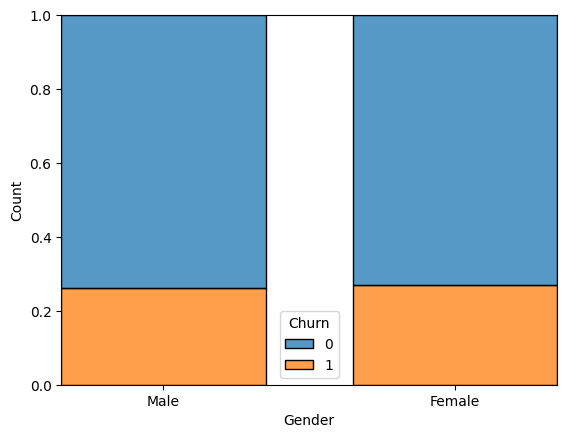

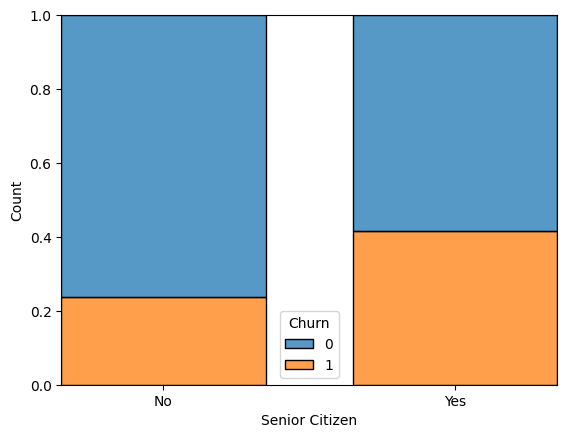

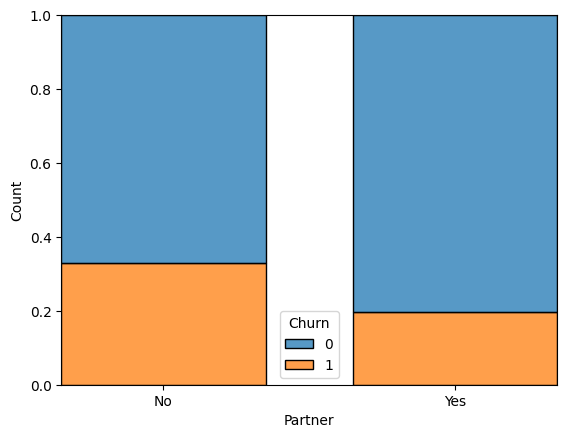

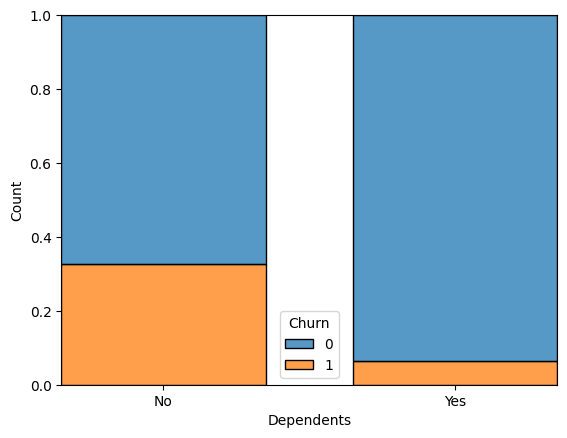

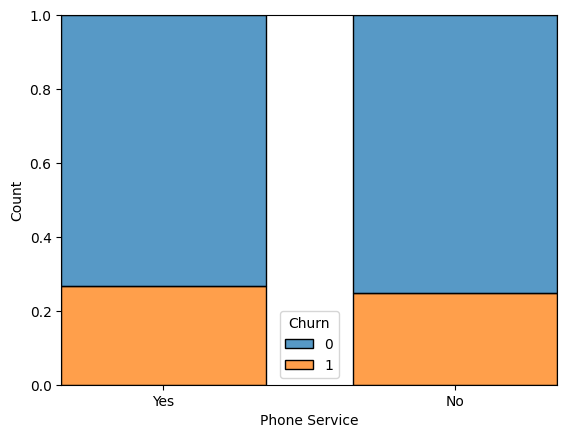

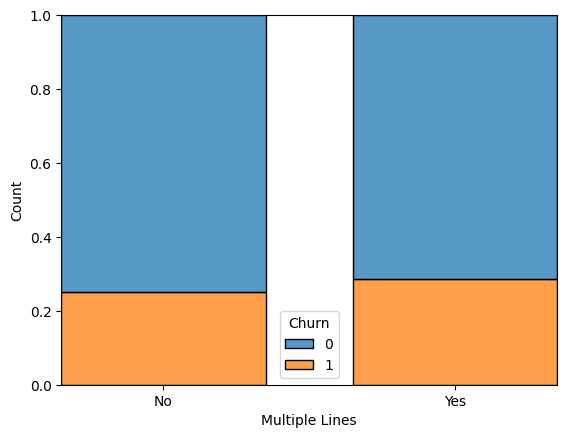

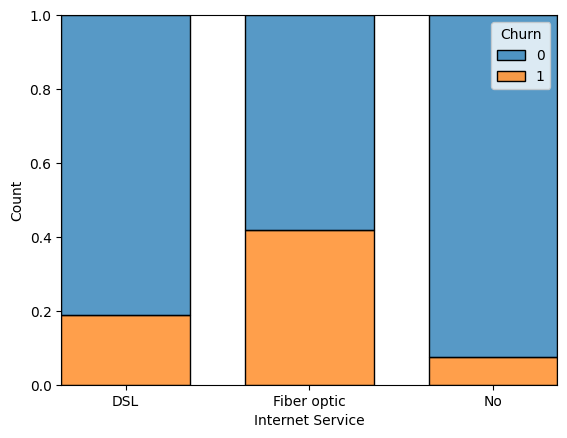

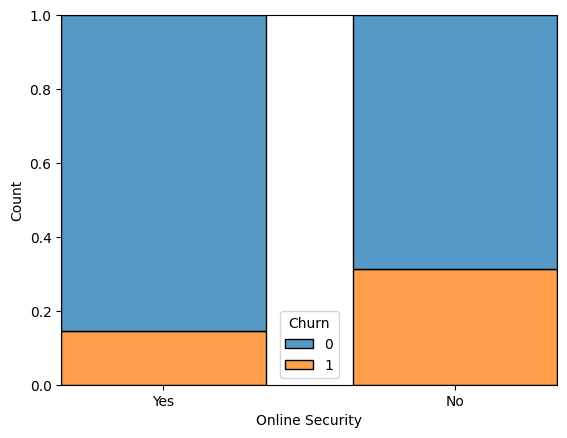

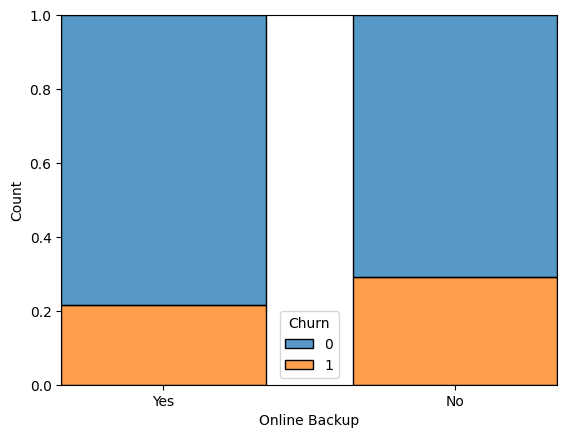

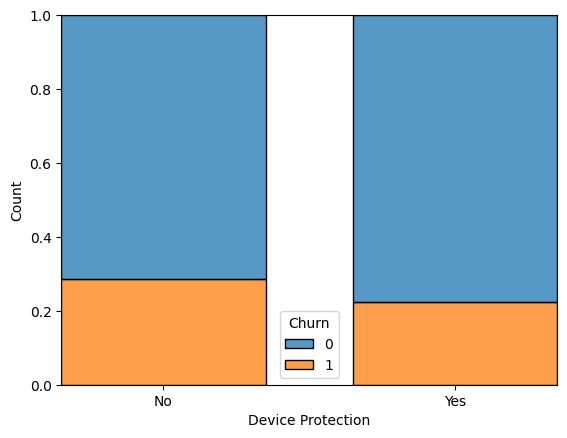

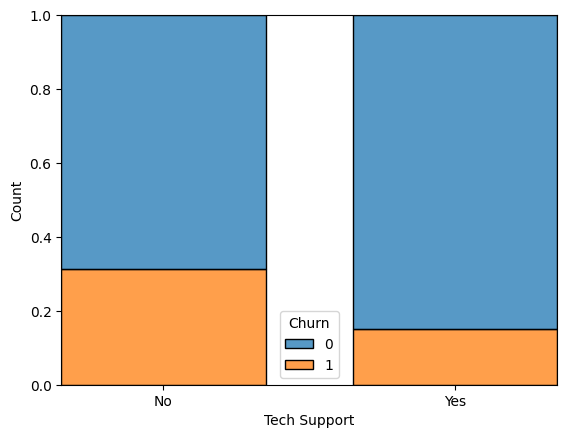

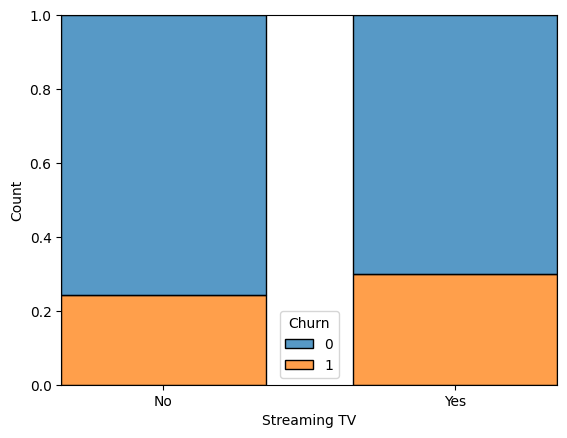

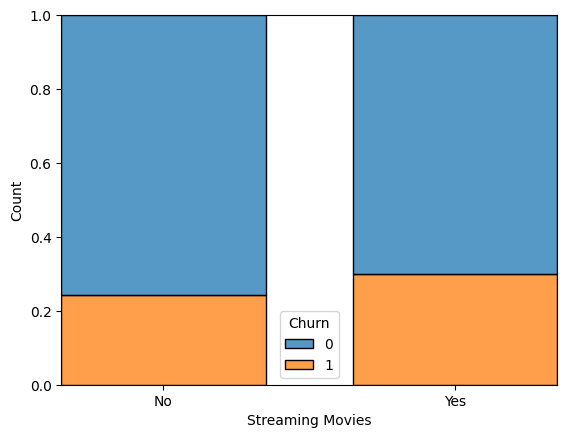

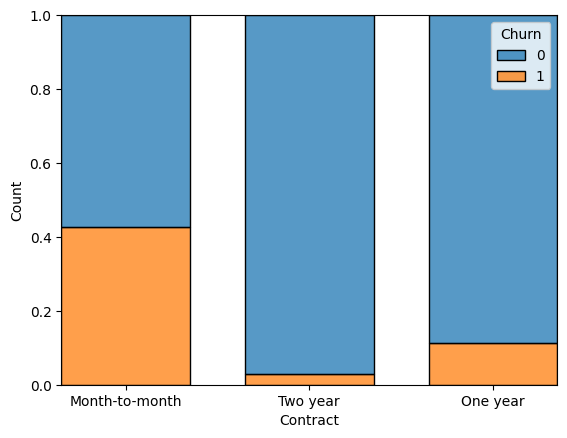

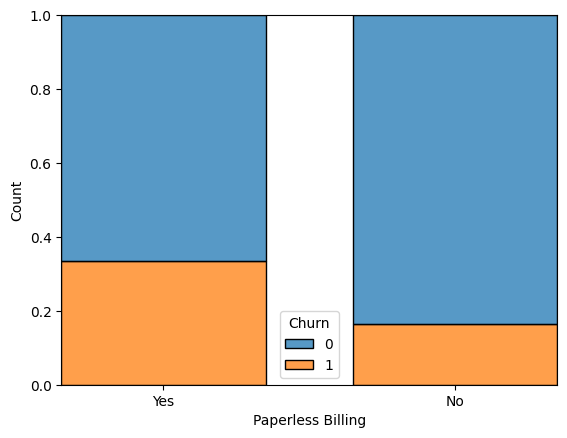

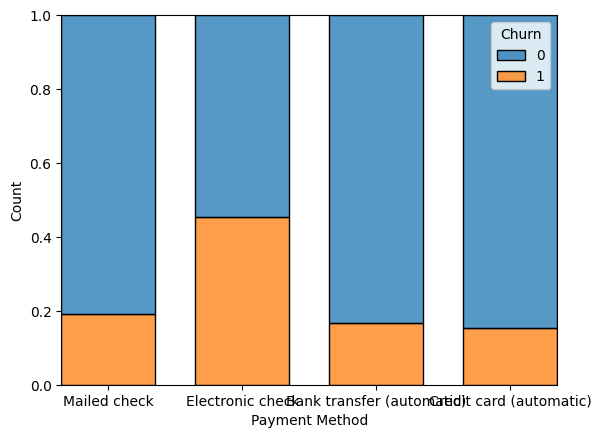

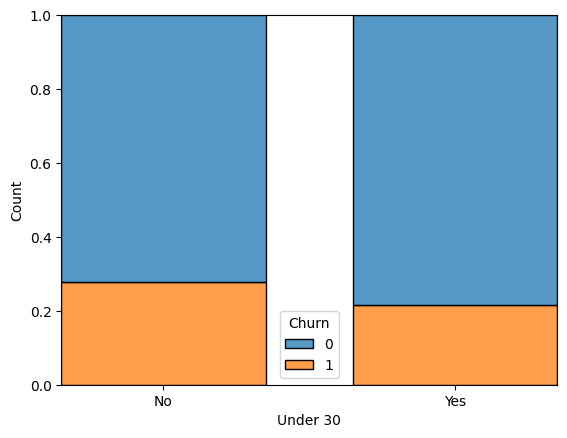

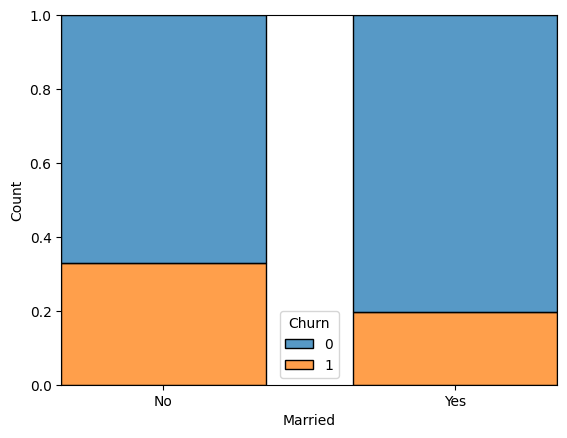

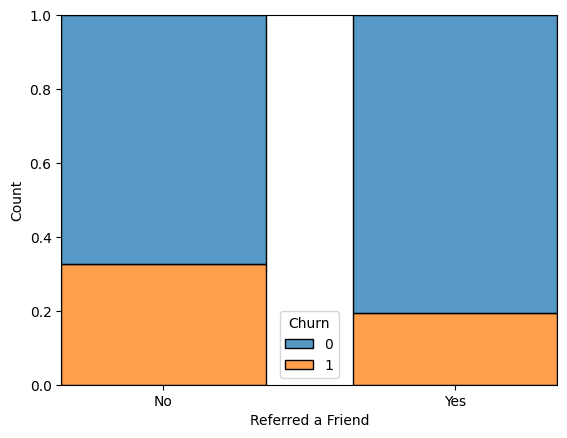

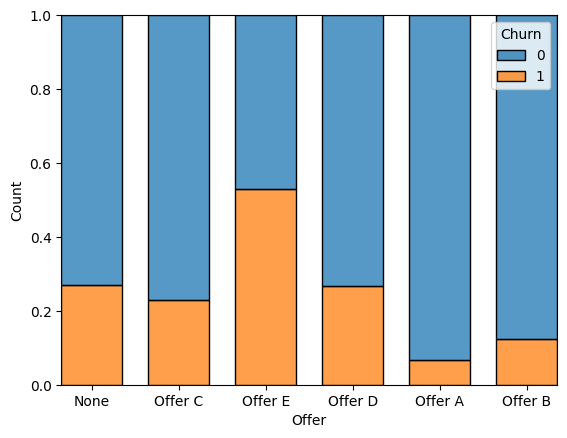

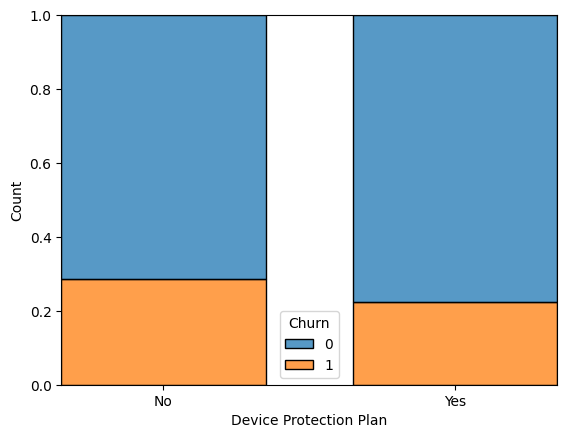

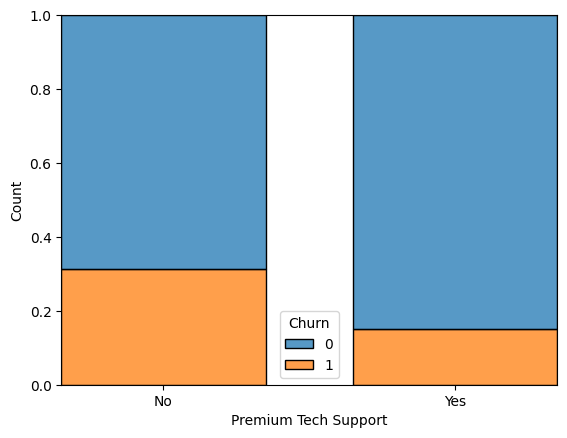

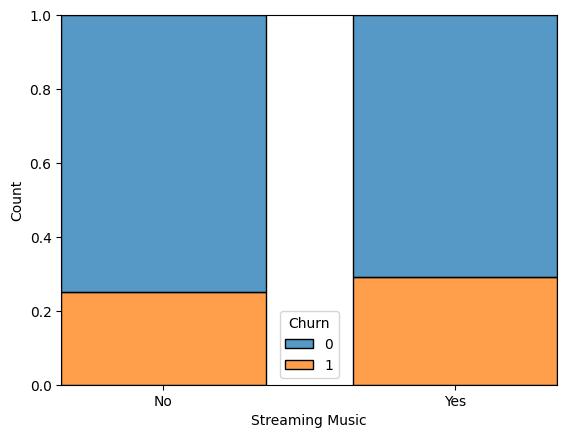

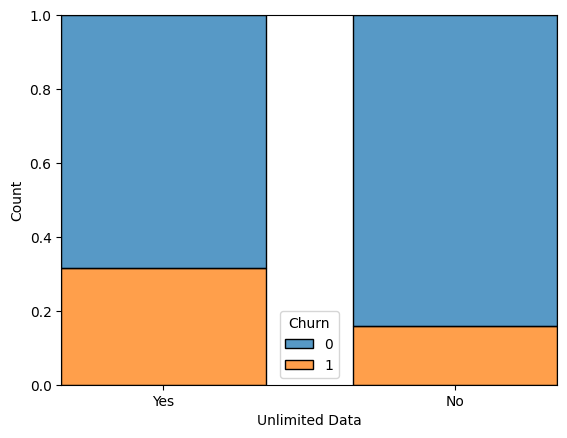

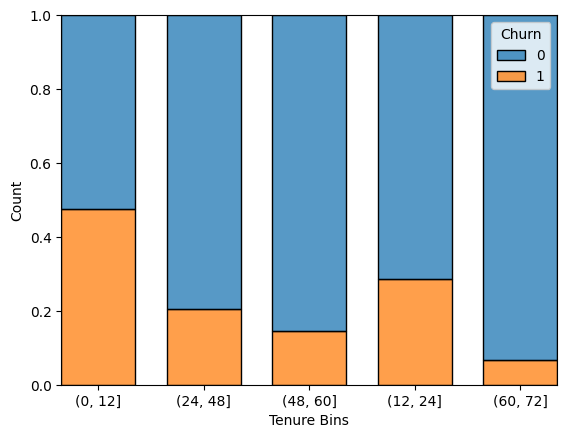

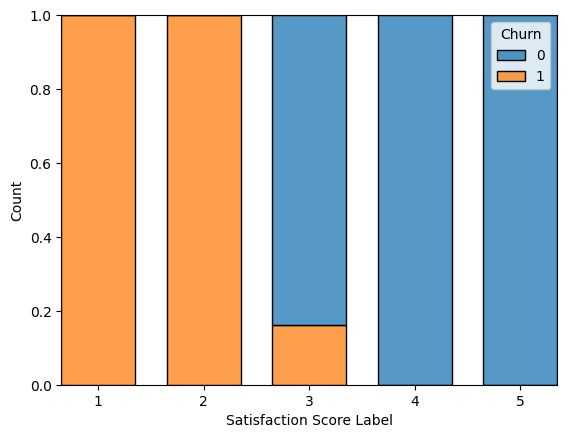

In [53]:
for col in df.columns.tolist():
    if col != "Churn" and df[col].dtype == 'object':
        plt.figure()
        sns.histplot(df, hue="Churn", x = col, shrink=.7, multiple="fill")
        plt.show()
    elif df[col].dtype == 'category':
        temp = df.copy()
        temp[col] = df[col].astype(str)
        plt.figure()
        sns.histplot(temp, hue="Churn", x = col, shrink=.7, multiple="fill")
        plt.show()

**Observations:** From the above plots we can see that:
- "Satisfaction Score Label" seems to be the biggest indicator of Churn as we can see almost anyone who rates our service 1 or 2 is most likely to churn so we must reach out to those users to take there feedback and resolve any issues, also users with rating 3 also have a chance of churning. So feedback ratings from users must be given very high importance.

- "Gender" doesn't seem to play any role in determining churn, 
- "Senior Citizens" seems to churn more than others, 
- People with No "Dependents" seem to churn more that the ones with dependents, 
- People with 'Fiber Optic' - "Internet service" tend to churn more, this maybe attributed to price. 
- Users with NO "Online Security" or NO "Tech Support" tend to churn more so we should focus on providing better security and tech support. 
- Users without automatic payement methods tend to churn more - we should try to automate the process as much as possible. 
- Users specifically with "Offer E" tend to churn more - we should take a closer look at that offer. 
- Customers using "Month to month" contract tend to churn more than others.
- The higher the "Tenure" the lower the churn seems to be the general trend.

## Bivariate Analysis

### Monthly Charges vs Total Charges

I performed a scatterplot to see how monthly charges varied with total charges, and from the plot below, we can see both attributes have a positive relationship.

In simple terms: This means as monthly charges increase the total charges increase. Also, we can see that as total charges increase churn (the red dots) becomes less.

<Axes: xlabel='Monthly Charges', ylabel='Total Charges'>

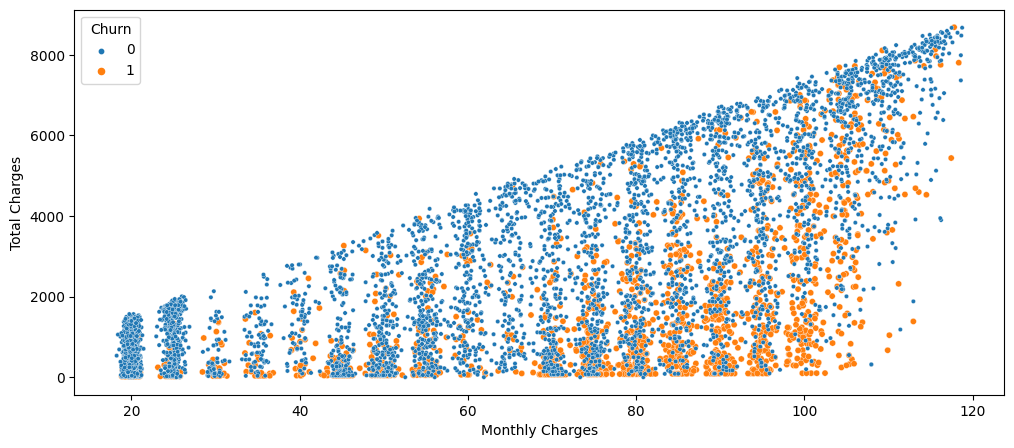

In [54]:
fig = plt.figure(figsize=(12,5))
sns.scatterplot(data = df, x = "Monthly Charges", y = "Total Charges", hue = "Churn", size="Churn", sizes=(20, 10),)

### Relationship Between Total Charges and Churn With Respect To Contract

<Axes: xlabel='Churn', ylabel='Total Charges'>

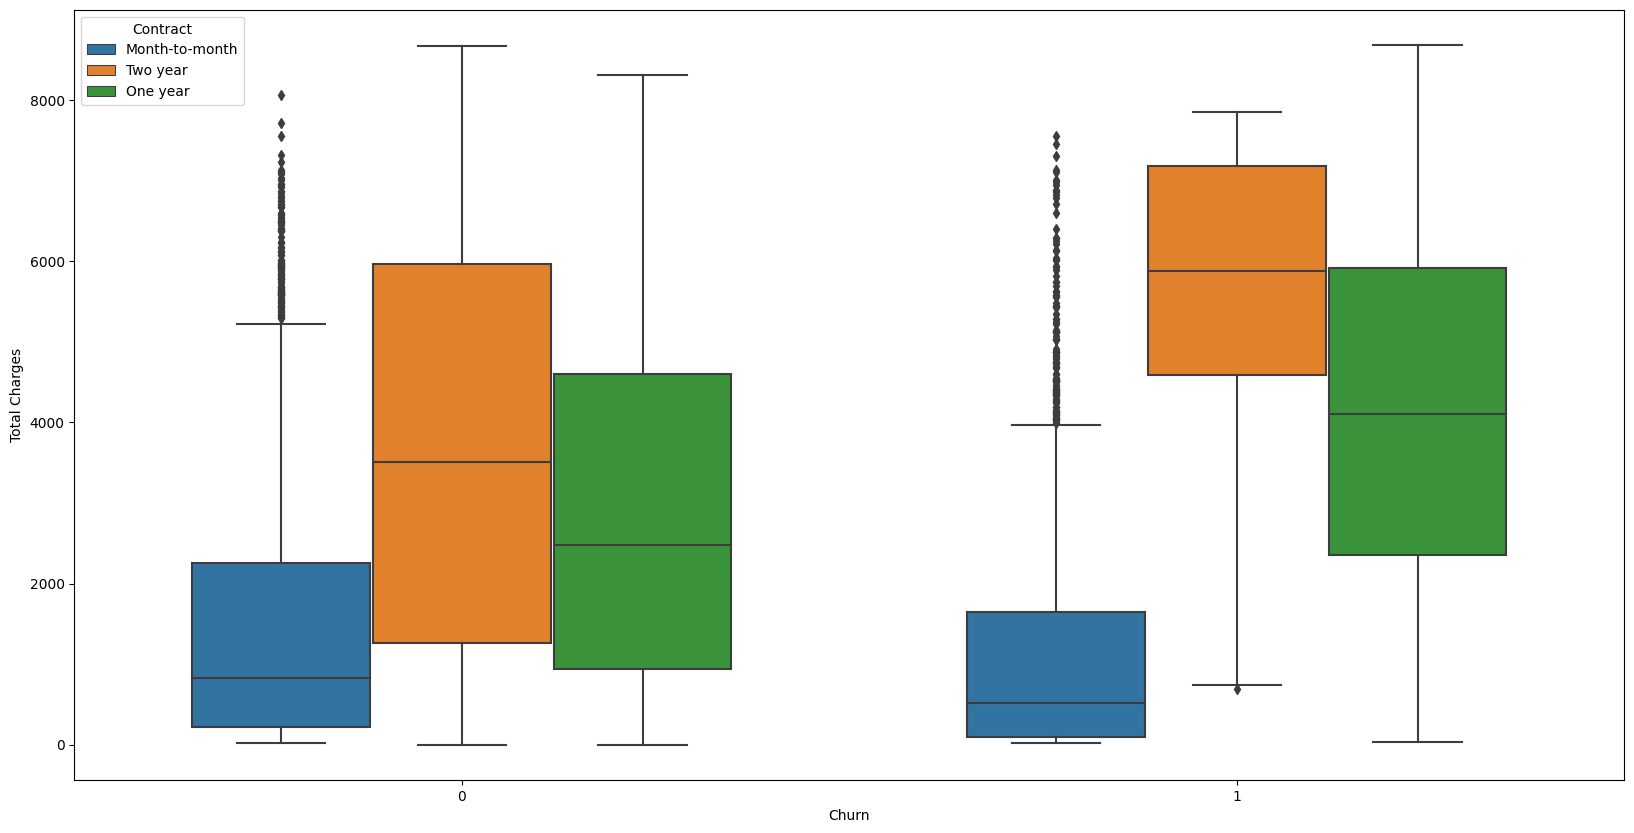

In [55]:
fig = plt.figure(figsize=(20,10))
sns.boxplot(data=df, x="Churn", y="Total Charges", hue="Contract", width = 0.7)

**Observation:** generally, churners were paying more total charges than non-churners

### Correlation between numerical feature

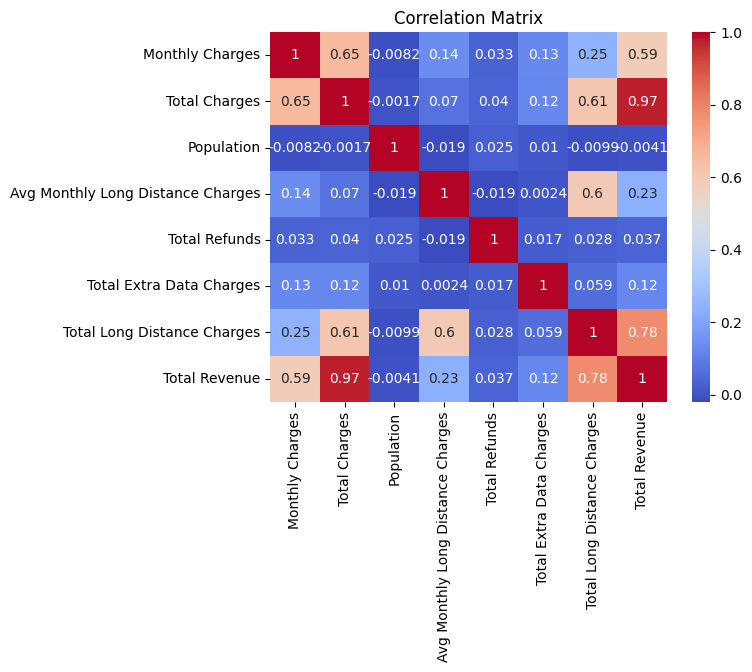

In [56]:
# Check the correlation matrix of all features
columns_for_corr = ["Monthly Charges", "Total Charges", "Population", "Avg Monthly Long Distance Charges", "Total Refunds", 
                    "Total Extra Data Charges", "Total Long Distance Charges", "Total Revenue"]
df_corr = df[columns_for_corr].corr()
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Observations:** 
- The Columns "Total Charges" and "Total Revenue" are very highly correlated as can be expected by there names. So will keep only one of them "Total Revenue" and remove other.
- The Columns "Monthly Charges" and "Total Long distance Charges" are also correlated to "Total Revenue" - we can also try and remove them.

In [57]:
#Columns to be droped 
columns_to_be_dropped = ["Total Charges", "Monthly Charges", "Total Long Distance Charges"]
df.drop(columns_to_be_dropped, axis = 1, inplace = True)

# Data Preperation

In [58]:
#we have this column also as a categorical column - so we can remove one of them
#df.drop(["Satisfaction Score"], axis = 1, inplace = True)
df.drop(["Satisfaction Score Label"], axis = 1, inplace = True)

 ## One-Hot Encoding for Categorical Columns - to be used in the model

In [59]:
columns_to_be_encoded = []

for col in df.columns.tolist():
    if(df[col].dtype == 'object' and "Yes" in df[col].unique()):
        columns_to_be_encoded.append(col)

df[columns_to_be_encoded] = np.where(df[columns_to_be_encoded] == "Yes", 1, 0)
df[columns_to_be_encoded] = df[columns_to_be_encoded].astype(int)

In [60]:
#We also need to ordinally encode "Gender" columns - from "Male" and "Female" to 0 and 1 for one-hot encoding
#we can also try to use two seperate columns
df["Gender"] = np.where(df["Gender"] == "Female", 1, 0)
df["Gender"] = df["Gender"].astype(int)

In [61]:
#one-hot encoding for Tenure bins #automatically removes the original categorical column
df = pd.get_dummies(df, columns = ["Tenure Bins", "Offer", "Payment Method", "Contract", "Internet Service"])

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 54 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Latitude                                  7043 non-null   float64
 1   Longitude                                 7043 non-null   float64
 2   Gender                                    7043 non-null   int32  
 3   Senior Citizen                            7043 non-null   int32  
 4   Partner                                   7043 non-null   int32  
 5   Dependents                                7043 non-null   int32  
 6   Phone Service                             7043 non-null   int32  
 7   Multiple Lines                            7043 non-null   int32  
 8   Online Security                           7043 non-null   int32  
 9   Online Backup                             7043 non-null   int32  
 10  Device Protection         

---
All data is now avaiable in numerical form now, which our models can easily utilize.

## Create X (features) and y (target) datasets

In [63]:
#try to handle imbalance dataset using techniques like SMOTE or other Over sampling or through Under Sampling

In [64]:
X = df.drop(["Churn"], axis = 1)
y = df["Churn"]

## Train, Test Split

In [65]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size = 0.2, shuffle = True)

In [66]:
#Confirm the splitting is correct:
print("Shape of Training Data : ", "\nfeatures:", X_train.shape, ", target:", y_train.shape)
print("Target Label Distribution in train set : ", "\nChurn:", y_train.sum(), "Not Churn", len(y_train) - y_train.sum())
print("Percentage of Churn:", y_train.sum() / len(y_train) * 100)
print()
print("Shape of Test Data : ", "\nfeatures:", X_test.shape, ", target:", y_test.shape)
print("Target Label Distribution in test set : ", "\nChurn:", y_test.sum(), "Not Churn", len(y_test) - y_test.sum())
print("Percentage of Churn:", y_test.sum() / len(y_test) * 100)

Shape of Training Data :  
features: (5634, 53) , target: (5634,)
Target Label Distribution in train set :  
Churn: 1495 Not Churn 4139
Percentage of Churn: 26.53532126375577

Shape of Test Data :  
features: (1409, 53) , target: (1409,)
Target Label Distribution in test set :  
Churn: 374 Not Churn 1035
Percentage of Churn: 26.54364797728886


In [67]:
#format the features names:

X.index.names = ['Customer_ID']
X_train.index.names = ['Customer_ID']
X_test.index.names = ['Customer_ID']

X.columns = [col.replace(' ', '_') for col in X.columns.tolist()]
X.columns = [col.replace('(', '_') for col in X.columns.tolist()]
X.columns = [col.replace(')', '') for col in X.columns.tolist()]
X.columns = [col.replace(']', '_') for col in X.columns.tolist()]
X.columns = [col.replace(',', '') for col in X.columns.tolist()]

X_train.columns = X.columns
X_test.columns = X.columns

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 53 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Latitude                                 7043 non-null   float64
 1   Longitude                                7043 non-null   float64
 2   Gender                                   7043 non-null   int32  
 3   Senior_Citizen                           7043 non-null   int32  
 4   Partner                                  7043 non-null   int32  
 5   Dependents                               7043 non-null   int32  
 6   Phone_Service                            7043 non-null   int32  
 7   Multiple_Lines                           7043 non-null   int32  
 8   Online_Security                          7043 non-null   int32  
 9   Online_Backup                            7043 non-null   int32  
 10  Device_Protection                     

# Modeling

## Creating and fitting Model

In [69]:
list_of_models = {
    'logistic_regression' : LogisticRegression(random_state = 42, max_iter = 10000),
    'decision_tree' : DecisionTreeClassifier(max_depth = 5, random_state = 42),
    'Random_forest' : RandomForestClassifier(n_estimators = 150, max_depth = 4, random_state = 42),
    'GBDT' : GradientBoostingClassifier(n_estimators = 150, max_depth = 4, random_state = 42),
    "XGBoost" : xgb.XGBClassifier(n_estimators = 200, max_depth = 5, random_state = 42)
}


For Model: logistic_regression

For Training Set:

Macro F1 Score: 0.9423462792576771

Confusion Matrix:


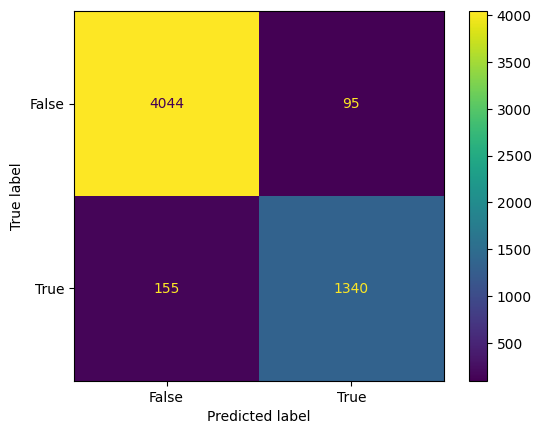

For Test Set:

Macro F1 Score: 0.9337130536363762

Confusion Matrix:


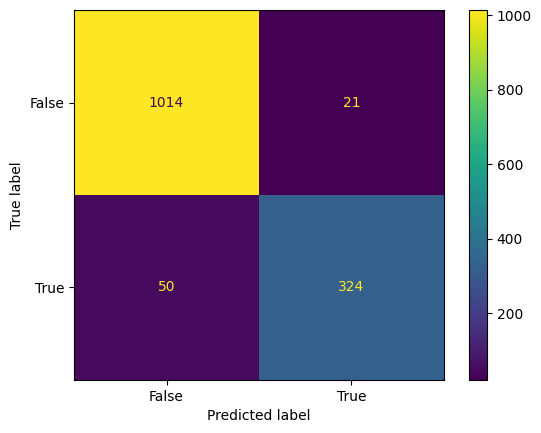


For Model: decision_tree

For Training Set:

Macro F1 Score: 0.9288065881929786

Confusion Matrix:


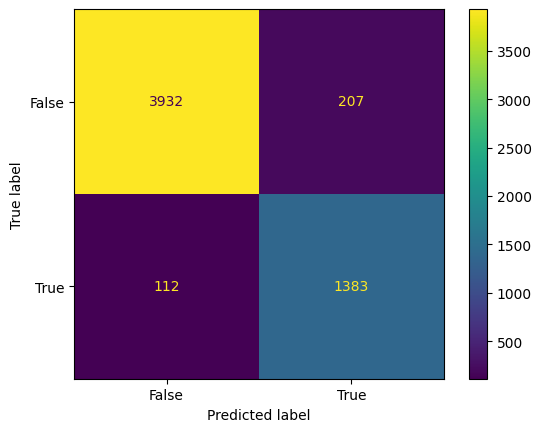

For Test Set:

Macro F1 Score: 0.924328678839957

Confusion Matrix:


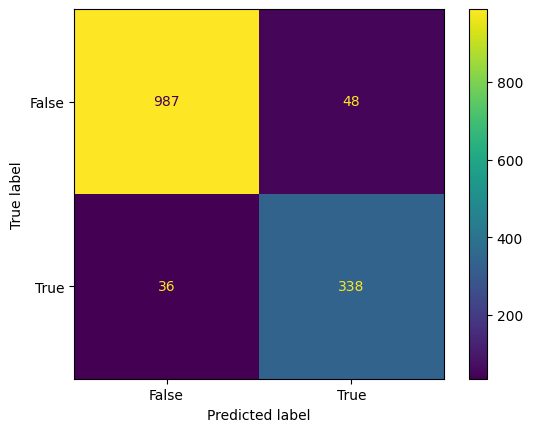


For Model: Random_forest

For Training Set:

Macro F1 Score: 0.9166953192077724

Confusion Matrix:


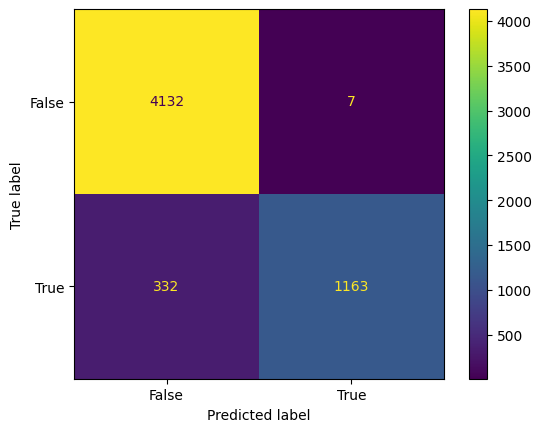

For Test Set:

Macro F1 Score: 0.9131265799371108

Confusion Matrix:


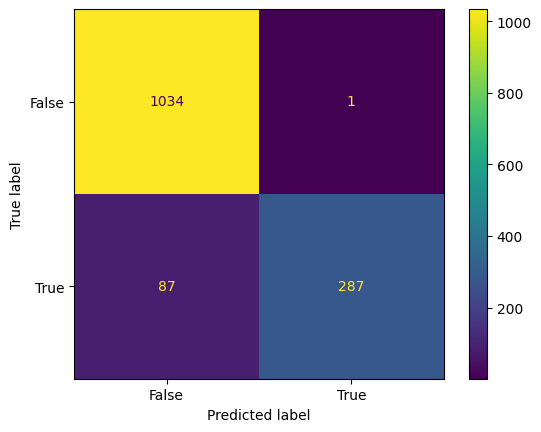


For Model: GBDT

For Training Set:

Macro F1 Score: 0.9829721225666059

Confusion Matrix:


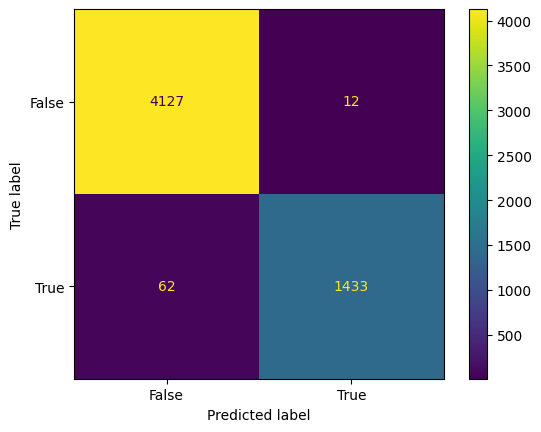

For Test Set:

Macro F1 Score: 0.9345868152274838

Confusion Matrix:


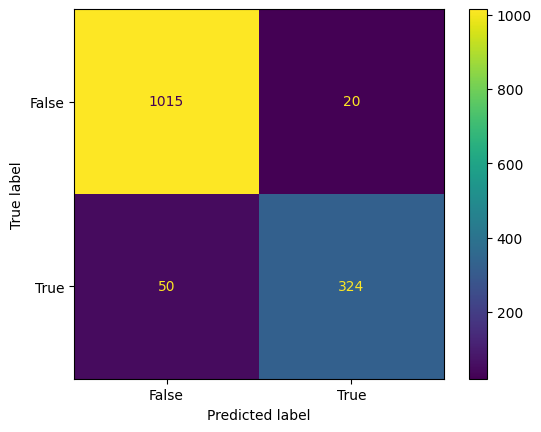

In [70]:
f1_train_scores = [] 
f1_test_scores = [] 
recall_test_scores = []

#model_names = list_of_models.keys()
model_names = ['logistic_regression', 'decision_tree', 'Random_forest', 'GBDT']
#model_names = ['GBDT']

for model in model_names:
    print("\nFor Model:", model)
    
    list_of_models[model].fit(X_train, y_train)

    print("\nFor Training Set:")

    y_train_pred = list_of_models[model].predict(X_train)

    f1_train = f1_score(y_train, y_train_pred, average='macro')
    print("\nMacro F1 Score:", f1_train)

    print("\nConfusion Matrix:") 
    confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

    print("For Test Set:")

    y_test_pred = list_of_models[model].predict(X_test)
    
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    print("\nMacro F1 Score:", f1_test)

    recall_test_score = recall_score(y_test, y_test_pred, average='macro')
    
    print("\nConfusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()
    
    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)
    recall_test_scores.append(recall_test_score)

**XGBoost**


For Model: XGBoost

For Training Set:

Macro F1 Score: 1.0

Confusion Matrix:


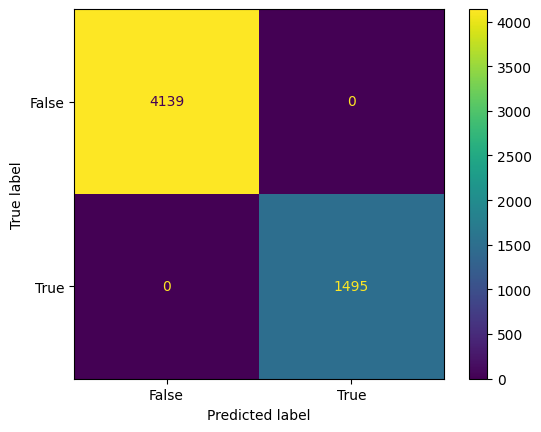

For Test Set:

Macro F1 Score: 0.937447529487848

Confusion Matrix:


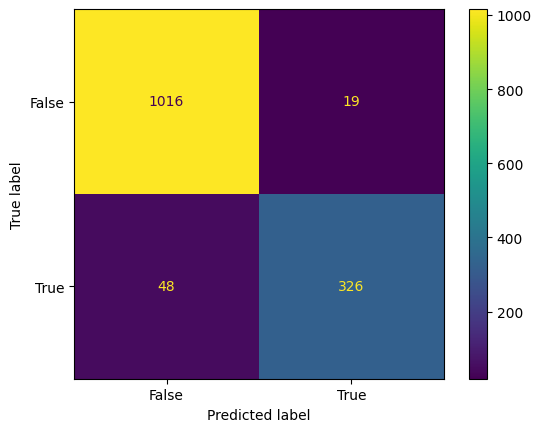

In [71]:
model = 'XGBoost'
model_names.append(model)

print("\nFor Model:", model)
    
list_of_models[model].fit(X_train, y_train)

print("\nFor Training Set:")

y_train_pred = list_of_models[model].predict(X_train)

f1_train = f1_score(y_train, y_train_pred, average='macro')
print("\nMacro F1 Score:", f1_train)

print("\nConfusion Matrix:") 
confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

print("For Test Set:")

y_test_pred = list_of_models[model].predict(X_test)

f1_test = f1_score(y_test, y_test_pred, average='macro')
print("\nMacro F1 Score:", f1_test)

recall_test_score = recall_score(y_test, y_test_pred, average='macro')

print("\nConfusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

f1_train_scores.append(f1_train)
f1_test_scores.append(f1_test)
recall_test_scores.append(recall_test_score)

## Model Performance Evaluation : Model Selection

In [72]:
res = pd.DataFrame({'model_names' : model_names, 'f1_train_scores' : f1_train_scores, 'f1_test_scores' : f1_test_scores, 'recall_test_scores' : recall_test_scores})
res

,model_names,f1_train_scores,f1_test_scores,recall_test_scores
0,logistic_regression,0.942346,0.933713,0.923010
1,decision_tree,0.928807,0.924329,0.928683
2,Random_forest,0.916695,0.913127,0.883207
3,GBDT,0.982972,0.934587,0.923493
4,XGBoost,1.000000,0.937448,0.926650


---
**Model Selection:**
The two of the best performing models are: "Gradient Boosted Decision Trees" and "XGBoost" - with XGBoost Performing slightly better in terms of both f1 score and recall.

Simple Logistic regression model also seems to be performing well on this classification task

## Learned Feature Importance

**Feature Importance of Logistic Regression Model**

<Axes: >

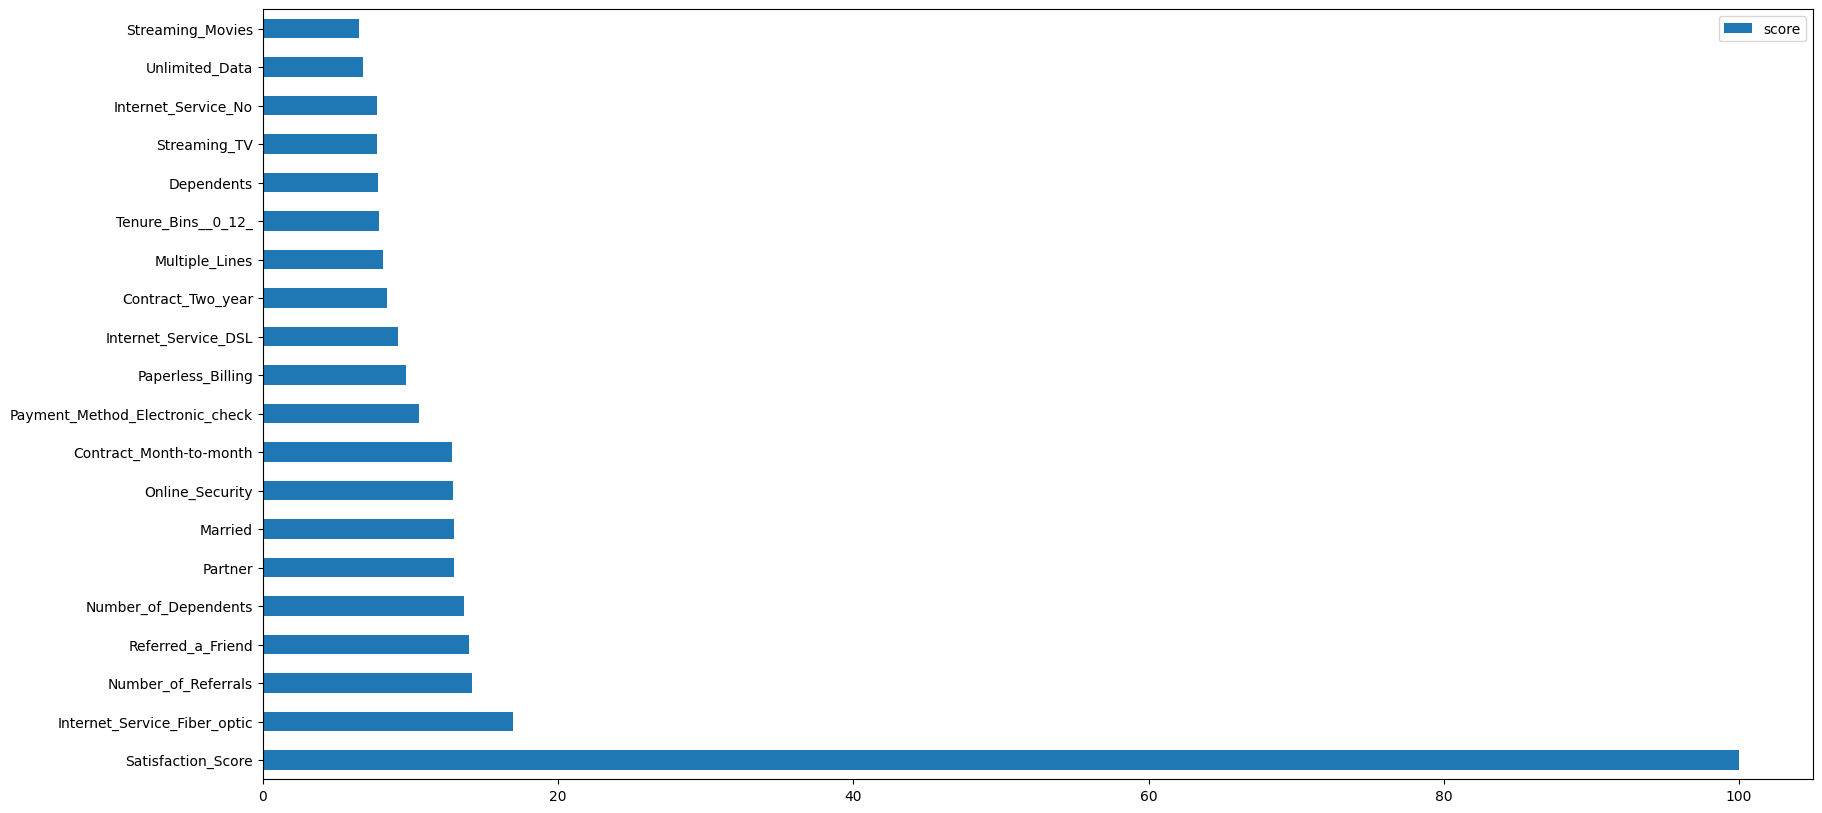

In [73]:
feature_importance = abs(list_of_models['logistic_regression'].coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

data = pd.DataFrame(data=feature_importance, index=X.columns, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10))

**Feature Importance of GBDT Model**

<Axes: >

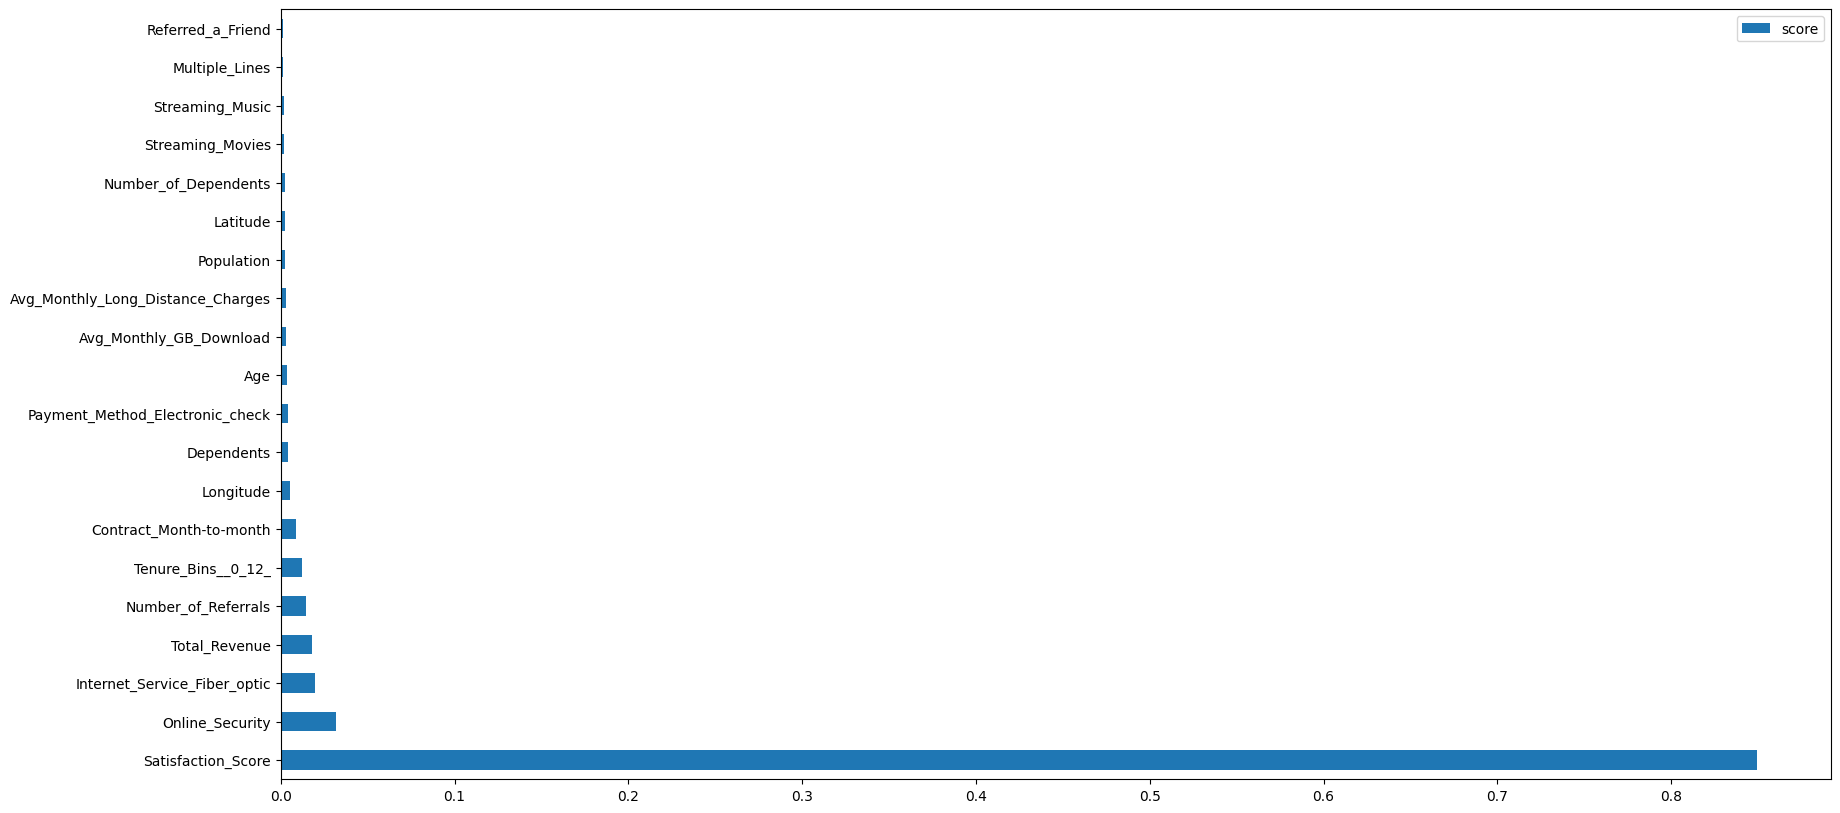

In [74]:
feature_importance = list_of_models['GBDT'].feature_importances_

data = pd.DataFrame(data=feature_importance, index=X.columns, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10))

**Feature Importance of XGBoost Model**
- Importance_type
    - *‘weight’* - the number of times a feature is used to split the data across all trees.
    - *‘gain’* - the average gain across all splits the feature is used in.

Feature Importance Gain


<Axes: >

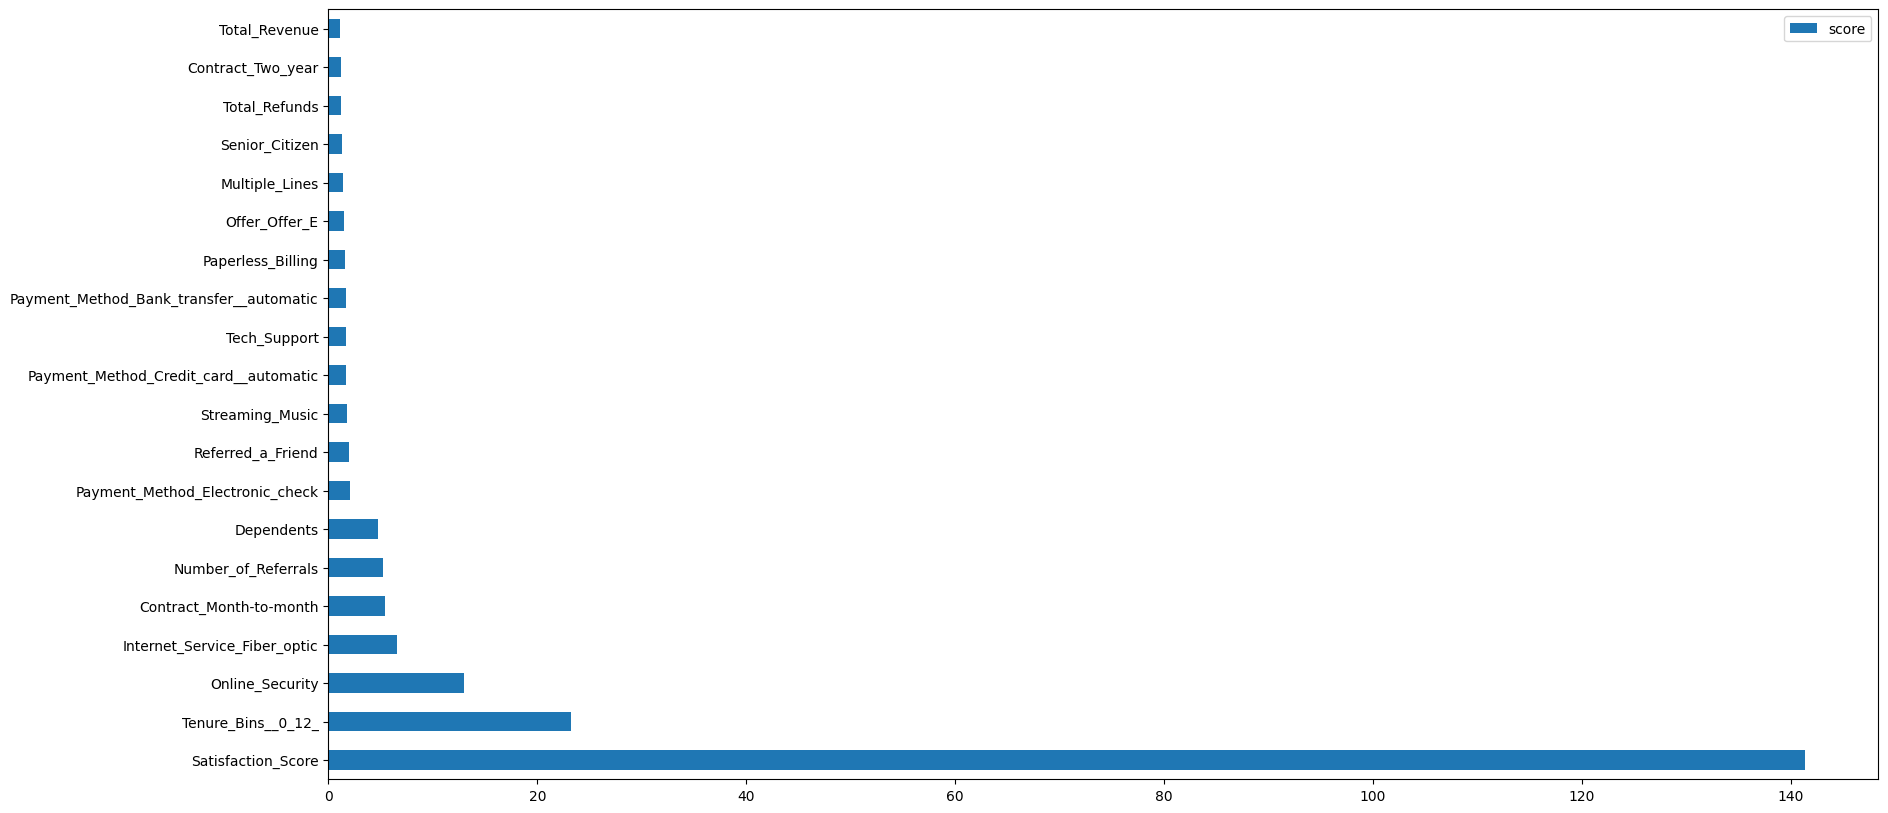

In [75]:
print("Feature Importance Gain")
feature_important = list_of_models["XGBoost"].get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

Feature Importance Weight


<Axes: >

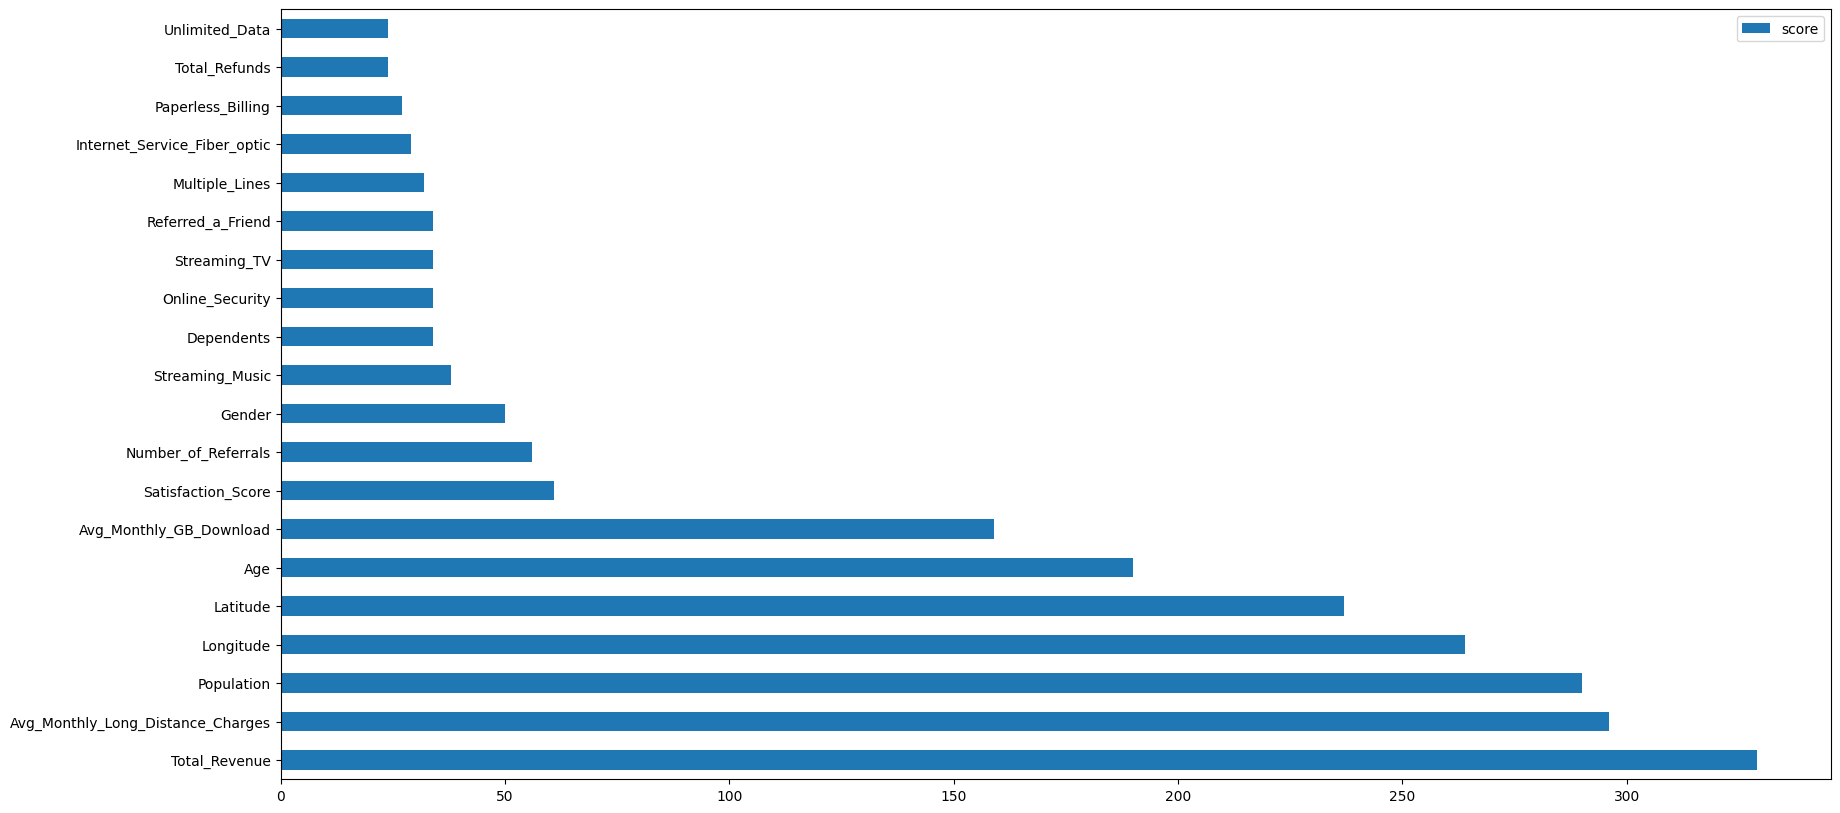

In [76]:
print("Feature Importance Weight")
feature_important = list_of_models[model].get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

## Save Model : Model Export as a Pickle File

In [77]:
pickle.dump(list_of_models['logistic_regression'], open(model_dir + 'churn_logistic_regression_model.pkl','wb'))
pickle.dump(list_of_models['GBDT'], open(model_dir + 'churn_GBDT_model.pkl','wb'))
pickle.dump(list_of_models['XGBoost'], open(model_dir + 'churn_XGBoost_model.pkl','wb'))

# Deployment

## Create Simpler models with less but more important features

In [78]:
#X.info()

For deployment we can create a simpler model with most important features learned by our models that way it is easier to make predictions with less details 

- We will ask for Zip code and map details like "Latitude", "Longitude" and "Population" from that.
- "Age" will be used to determine the features such as "Senior Citizen" and "Under_30"

- So the features that will be used for final deployment model are:
    - Satisfaction Score
    - Total Revenue
    - Tenure
    - Contract
    - Internet Service
    - Online Security
    - Paperless Billing
    - Offer
    - Referred_a_Friend
    - Tech_Support
    - Married
    - Age
    - Zip Code
    - Payement Method

In [79]:
#select the columns
cols_to_drop = ['Gender', 'Partner', 'Total_Extra_Data_Charges', 'Total_Refunds', 
                'Premium_Tech_Support', 'Streaming_Music', 'Unlimited_Data',
                'Number_of_Referrals', 'Avg_Monthly_Long_Distance_Charges', 
                'Avg_Monthly_GB_Download', 'Device_Protection_Plan',
                'Number_of_Dependents', 'Streaming_TV', 'Streaming_Movies',
                'Online_Backup', 'Device_Protection', 'Dependents', 'Phone_Service', 'Multiple_Lines']
X.drop(cols_to_drop, axis = 1, inplace = True)

In [80]:
#X.info()

In [81]:
X_train.drop(cols_to_drop, axis = 1, inplace = True)
X_test.drop(cols_to_drop, axis = 1, inplace = True)
X_train = X_train.values
X_test = X_test.values

In [82]:
#Create Models 
#logistic regression Model for deployement with selected features
log_reg_model = LogisticRegression(random_state = 42, max_iter = 10000)


For Training Set:

Macro F1 Score: 0.9338930756813087

Confusion Matrix:


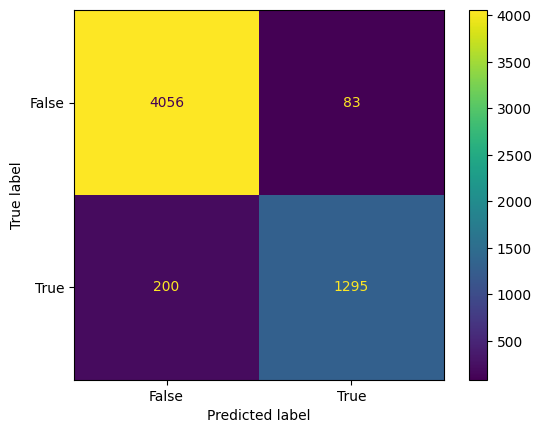

For Test Set:

Macro F1 Score: 0.9290612318877063

Macro Recall Score: 0.9133935260533725

Confusion Matrix:


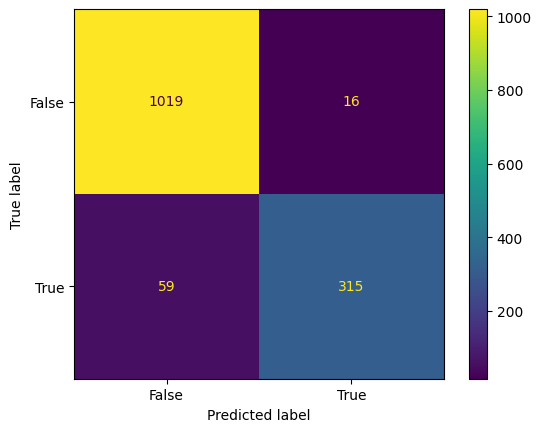

In [83]:
#fit model
log_reg_model.fit(X_train, y_train)

#make predictions on train and test set
print("\nFor Training Set:")

y_train_pred = log_reg_model.predict(X_train)

f1_train = f1_score(y_train, y_train_pred, average='macro')
print("\nMacro F1 Score:", f1_train)

print("\nConfusion Matrix:") 
confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

print("For Test Set:")

y_test_pred = log_reg_model.predict(X_test)

f1_test = f1_score(y_test, y_test_pred, average='macro')
print("\nMacro F1 Score:", f1_test)

recall_test_score = recall_score(y_test, y_test_pred, average='macro')
print("\nMacro Recall Score:", recall_test_score)

print("\nConfusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [84]:
xgb_model = xgb.XGBClassifier(n_estimators = 200, max_depth = 5, random_state = 42)


For Training Set:

Macro F1 Score: 1.0

Confusion Matrix:


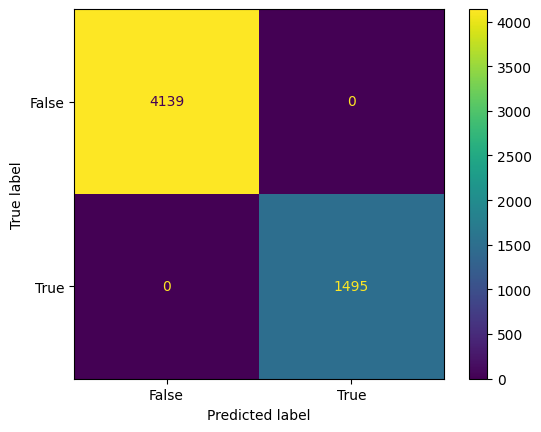

For Test Set:

Macro F1 Score: 0.9333457706056174

Macro Recall Score: 0.9204487328528249

Confusion Matrix:


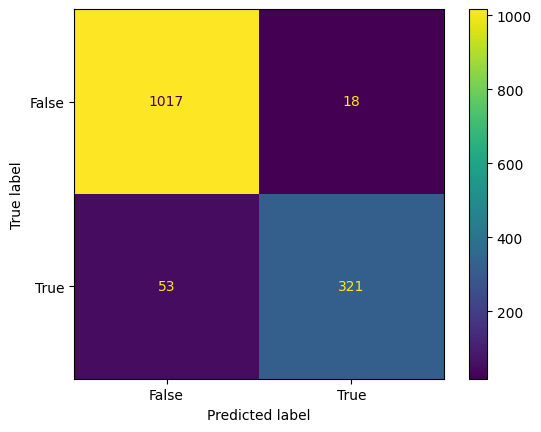

In [85]:
#fit model
xgb_model.fit(X_train, y_train)

#make predictions on train and test set
print("\nFor Training Set:")

y_train_pred = xgb_model.predict(X_train)

f1_train = f1_score(y_train, y_train_pred, average='macro')
print("\nMacro F1 Score:", f1_train)

print("\nConfusion Matrix:") 
confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

print("For Test Set:")

y_test_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_test_pred, average='macro')
print("\nMacro F1 Score:", f1_test)

recall_test_score = recall_score(y_test, y_test_pred, average='macro')
print("\nMacro Recall Score:", recall_test_score)

print("\nConfusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Even with less number of features we get similar performance in models.

In [86]:
#Save and export models to be used in deployment 

pickle.dump(log_reg_model, open(model_dir + 'churn_logistic_regression_model_for_deployment.pkl','wb'))
pickle.dump(xgb_model, open(model_dir + 'churn_xgb_model_for_deployment.pkl','wb'))

## Model Ensemble

**Creating an ensemble model by combining the two model's predictions of probability of churning**


For Training Set:

Macro F1 Score: 0.9954667939032642

Macro Recall Score: 0.9975839574776516

Confusion Matrix:


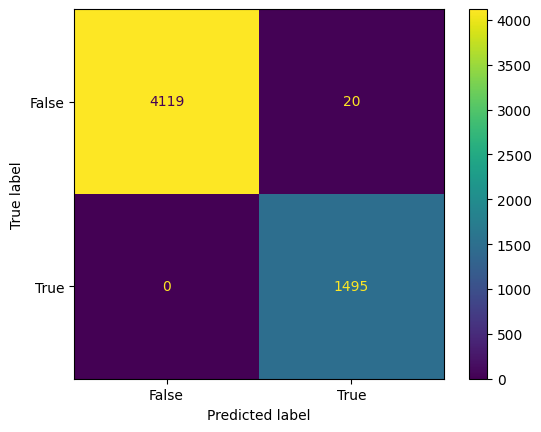

In [148]:
y_pred_proba_log = [x[1] for x in log_reg_model.predict_proba(X_train)]
y_pred_proba_xgb = [x[1] for x in xgb_model.predict_proba(X_train)]
y_pred_proba_log = np.array(y_pred_proba_log)
y_pred_proba_xgb = np.array(y_pred_proba_xgb)

res = np.array(y_pred_proba_log + y_pred_proba_xgb) / 2.0

res = np.where(res > 0.4, 1, 0)

#make predictions on train and test set
print("\nFor Training Set:")

f1_train = f1_score(y_train, res, average='macro')
print("\nMacro F1 Score:", f1_train)

recall_train_score = recall_score(y_train, res, average='macro')
print("\nMacro Recall Score:", recall_train_score)

print("\nConfusion Matrix:") 
confusion_matrix = metrics.confusion_matrix(y_train, res)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [145]:
y_pred_proba_log = [x[1] for x in log_reg_model.predict_proba(X_test)]
y_pred_proba_xgb = [x[1] for x in xgb_model.predict_proba(X_test)]
y_pred_proba_log = np.array(y_pred_proba_log)
y_pred_proba_xgb = np.array(y_pred_proba_xgb)

y_pred_proba = (y_pred_proba_log + y_pred_proba_xgb) / 2.0

y_test_pred = np.where(y_pred_proba > 0.4, 1, 0)

For Test Set:

Macro F1 Score: 0.937787370051238

Macro Recall Score: 0.9292115528688418

Confusion Matrix:


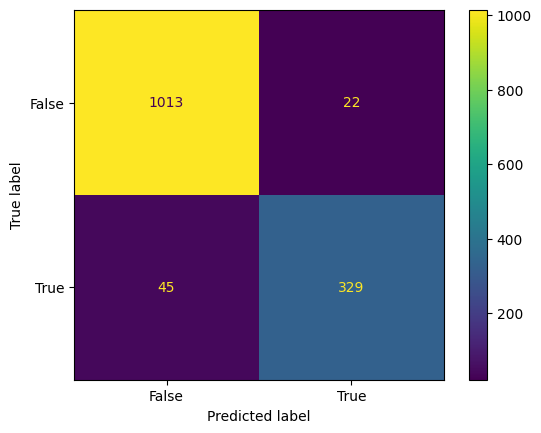

In [146]:
print("For Test Set:")

f1_test = f1_score(y_test, y_test_pred, average='macro')
print("\nMacro F1 Score:", f1_test)

recall_test_score = recall_score(y_test, y_test_pred, average='macro')
print("\nMacro Recall Score:", recall_test_score)

print("\nConfusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

**Observations:** 
Using ensemble model of simple logistic regression model and Xgboost - we achieve even better f1 score and using a 0.4 as threshold for classifying as churn we can greatly improve our recall score - which matters more in our case as we want to classify all customers who might churn and don't want to miss any.

## Final Model : Train model on complete dataset

finally we can train our models on overall data for better performance in real life deployment 


Macro F1 Score: 0.9951063298400236

Macro Recall Score: 0.9973908001546192

Confusion Matrix:


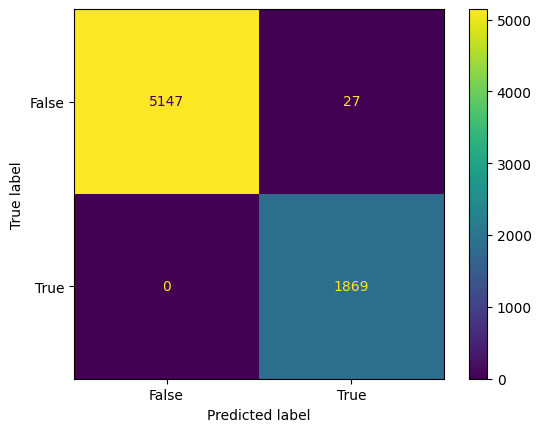

In [151]:
#fit logistic regression model
log_reg_model.fit(X, y)

#fit xgb model
xgb_model.fit(X, y)

#predict using ensemble of both the models
y_pred_proba_log = [x[1] for x in log_reg_model.predict_proba(X)]
y_pred_proba_xgb = [x[1] for x in xgb_model.predict_proba(X)]
y_pred_proba_log = np.array(y_pred_proba_log)
y_pred_proba_xgb = np.array(y_pred_proba_xgb)

y_pred_proba = (y_pred_proba_log + y_pred_proba_xgb) / 2.0

y_pred = np.where(y_pred_proba > 0.4, 1, 0)

f1 = f1_score(y, y_pred, average = 'macro')
print("\nMacro F1 Score:", f1)

recall = recall_score(y, y_pred, average = 'macro')
print("\nMacro Recall Score:", recall)

print("\nConfusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [152]:
#Save and export models to be used in deployment 
pickle.dump(log_reg_model, open(model_dir + 'churn_logistic_regression_model_for_deployment.pkl','wb'))
pickle.dump(xgb_model, open(model_dir + 'churn_xgb_model_for_deployment.pkl','wb'))

## Mapping from Zip code to other information

Combine both tables so we can get Population, latitude and longitude information using just the zip code of user.

In [87]:
population_df = pd.read_csv(base_dir + 'Telco_customer_churn_population.csv', usecols = ["Zip Code", "Population"])
location_df = pd.read_csv(base_dir + 'Telco_customer_churn_location.csv', usecols = ["Zip Code", "Latitude", 'Longitude'])
population_df["Population"] = population_df['Population'].str.replace(',','').astype(int)

#merge dataframes
zip_code_map_df = pd.merge(location_df, population_df, on = "Zip Code", how = "left", suffixes=('', '_remove'))
zip_code_map_df = zip_code_map_df.drop_duplicates()
zip_code_map_df = zip_code_map_df.set_index("Zip Code")

#save the new map in a csv to be used later 
zip_code_map_df.to_csv(csv_dir + "zip_code_map_df.csv")

In [88]:
#how to select details about a specific zip code
zip_code_map_df.loc[92250]

Latitude        32.811001
Longitude     -115.152865
Population    8062.000000
Name: 92250, dtype: float64

In [89]:
#Zip code with Maximum Population
print(zip_code_map_df[zip_code_map_df.Population == zip_code_map_df.Population.max()])

           Latitude   Longitude  Population
Zip Code                                   
90201     33.970343 -118.171368      105285


# Summary / Insights

**Learned Feature Importance**

From the above, We see that Logistic Regression, Gradient Boosted Decision Trees and XGBoost (eXtreme Gradient Boosted Trees) can be used for customer churn analysis for this particular dataset equally fine.

Throughout the analysis, I have learned several important things:

- Features such as Customer Satisfaction Score, Tenure Group, Contract, InternetService, Payement Method, Online Security, Total Revenue and Paperless Billing appear to play a role in customer churn.

- There does not seem to be a relationship between gender and churn.

- Most Importantly the customers which have given a low satisfaction score in feedback are most likely to churn, so we must reach out to them as soon as posible to resolve any issues present.

**Model Ensemble** 

Using ensemble model of simple *"logistic regression"* and *"Xgboost"* models - we achive even better f1 score and using a 0.4 as threshold for classifing as churn we can greatly improve our recall score - which matters more in our case as we want to classify all customers who might churn and don't want to miss any.